In [ ]:
import os
import yaml
import json

os.chdir('/home/ray/DeepMSN/')

In [ ]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from datasets.topic_datasets import TopicDataset
from models.deepflybrain import DeepFlyBrain

device = torch.device(f'cuda:0')
print(f"Using {device} device")

In [ ]:
with open('configs/config_ctdnsmpl_top2k.yaml', 'r') as f:
    config = yaml.safe_load(f)

checkpoint_path = config.get('train').get('checkpoint').get('path')
checkpoint_path

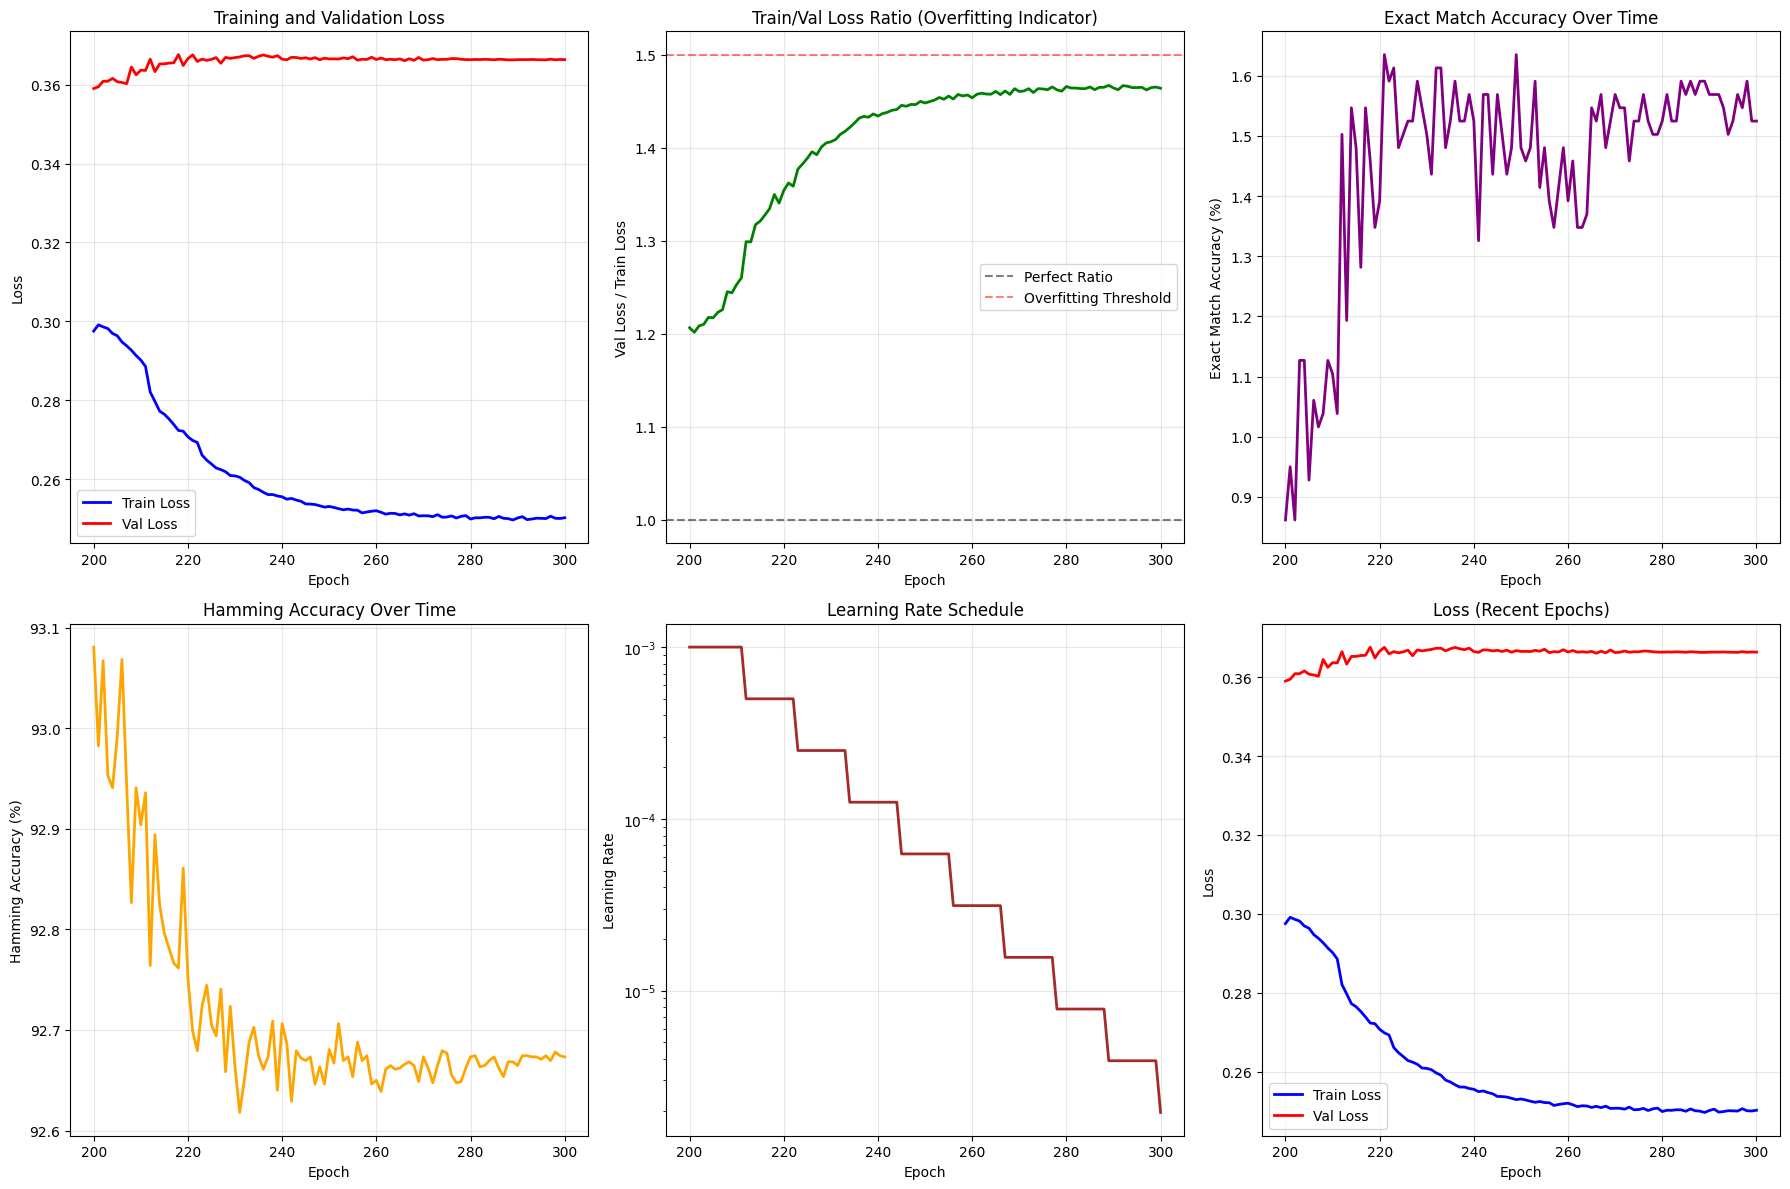

Training Summary:
Initial Train Loss: 0.297552
Final Train Loss: 0.250254
Initial Val Loss: 0.358998
Final Val Loss: 0.366330
Best Val Loss: 0.358998 (Epoch 200)
Best Exact Match Acc: 0.0163 (Epoch 221)
Best Hamming Acc: 0.9308 (Epoch 200)
Final Train/Val Ratio: 1.464


In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Load the training log
training_df = pd.read_csv(f'{checkpoint_path}/training_log.csv')

# Create comprehensive training plots
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# 1. Training and Validation Loss
axes[0, 0].plot(training_df['epoch'], training_df['train_loss'], 'b-', label='Train Loss', linewidth=2)
axes[0, 0].plot(training_df['epoch'], training_df['val_loss'], 'r-', label='Val Loss', linewidth=2)
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Loss')
axes[0, 0].set_title('Training and Validation Loss')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# 2. Train/Val Loss Ratio (Overfitting indicator)
axes[0, 1].plot(training_df['epoch'], training_df['train_val_ratio'], 'g-', linewidth=2)
axes[0, 1].axhline(y=1.0, color='k', linestyle='--', alpha=0.5, label='Perfect Ratio')
axes[0, 1].axhline(y=1.5, color='r', linestyle='--', alpha=0.5, label='Overfitting Threshold')
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('Val Loss / Train Loss')
axes[0, 1].set_title('Train/Val Loss Ratio (Overfitting Indicator)')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# 3. Exact Match Accuracy
axes[0, 2].plot(training_df['epoch'], training_df['exact_match_acc'] * 100, 'purple', linewidth=2)
axes[0, 2].set_xlabel('Epoch')
axes[0, 2].set_ylabel('Exact Match Accuracy (%)')
axes[0, 2].set_title('Exact Match Accuracy Over Time')
axes[0, 2].grid(True, alpha=0.3)

# 4. Hamming Accuracy
axes[1, 0].plot(training_df['epoch'], training_df['hamming_acc'] * 100, 'orange', linewidth=2)
axes[1, 0].set_xlabel('Epoch')
axes[1, 0].set_ylabel('Hamming Accuracy (%)')
axes[1, 0].set_title('Hamming Accuracy Over Time')
axes[1, 0].grid(True, alpha=0.3)

# 5. Learning Rate Schedule
axes[1, 1].plot(training_df['epoch'], training_df['learning_rate'], 'brown', linewidth=2)
axes[1, 1].set_xlabel('Epoch')
axes[1, 1].set_ylabel('Learning Rate')
axes[1, 1].set_title('Learning Rate Schedule')
axes[1, 1].set_yscale('log')
axes[1, 1].grid(True, alpha=0.3)

# 6. Loss Comparison (zoomed view of recent epochs)
recent_epochs = training_df['epoch'] >= 50  # Show last part of training
axes[1, 2].plot(training_df[recent_epochs]['epoch'], 
                training_df[recent_epochs]['train_loss'], 'b-', label='Train Loss', linewidth=2)
axes[1, 2].plot(training_df[recent_epochs]['epoch'], 
                training_df[recent_epochs]['val_loss'], 'r-', label='Val Loss', linewidth=2)
axes[1, 2].set_xlabel('Epoch')
axes[1, 2].set_ylabel('Loss')
axes[1, 2].set_title('Loss (Recent Epochs)')
axes[1, 2].legend()
axes[1, 2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print summary statistics
print("Training Summary:")
print(f"Initial Train Loss: {training_df['train_loss'].iloc[0]:.6f}")
print(f"Final Train Loss: {training_df['train_loss'].iloc[-1]:.6f}")
print(f"Initial Val Loss: {training_df['val_loss'].iloc[0]:.6f}")
print(f"Final Val Loss: {training_df['val_loss'].iloc[-1]:.6f}")
print(f"Best Val Loss: {training_df['val_loss'].min():.6f} (Epoch {training_df.loc[training_df['val_loss'].idxmin(), 'epoch']})")
print(f"Best Exact Match Acc: {training_df['exact_match_acc'].max():.4f} (Epoch {training_df.loc[training_df['exact_match_acc'].idxmax(), 'epoch']})")
print(f"Best Hamming Acc: {training_df['hamming_acc'].max():.4f} (Epoch {training_df.loc[training_df['hamming_acc'].idxmax(), 'epoch']})")
print(f"Final Train/Val Ratio: {training_df['train_val_ratio'].iloc[-1]:.3f}")

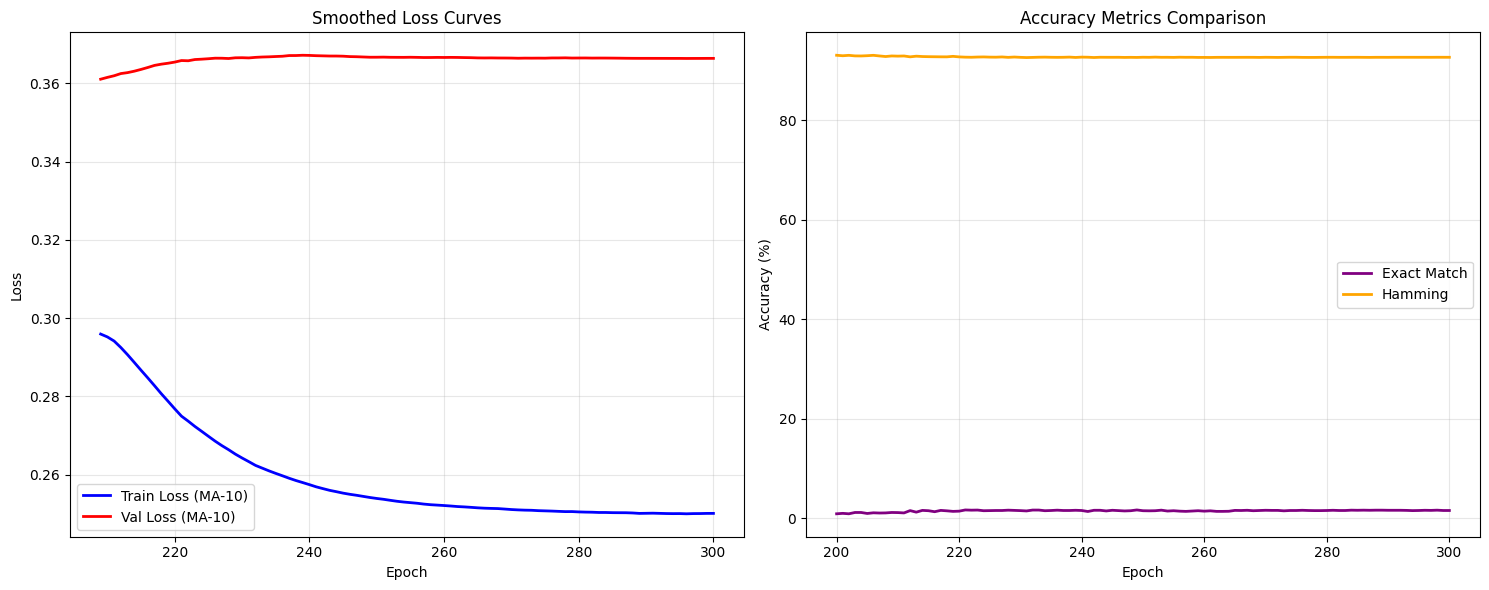

In [7]:
# Additional analysis plots

# Plot 1: Loss improvement over time
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Moving average to smooth curves
window = 10
train_loss_smooth = training_df['train_loss'].rolling(window=window).mean()
val_loss_smooth = training_df['val_loss'].rolling(window=window).mean()

axes[0].plot(training_df['epoch'], train_loss_smooth, 'b-', label=f'Train Loss (MA-{window})', linewidth=2)
axes[0].plot(training_df['epoch'], val_loss_smooth, 'r-', label=f'Val Loss (MA-{window})', linewidth=2)
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title('Smoothed Loss Curves')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Accuracy comparison
axes[1].plot(training_df['epoch'], training_df['exact_match_acc'] * 100, 
             'purple', label='Exact Match', linewidth=2)
axes[1].plot(training_df['epoch'], training_df['hamming_acc'] * 100, 
             'orange', label='Hamming', linewidth=2)
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy (%)')
axes[1].set_title('Accuracy Metrics Comparison')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

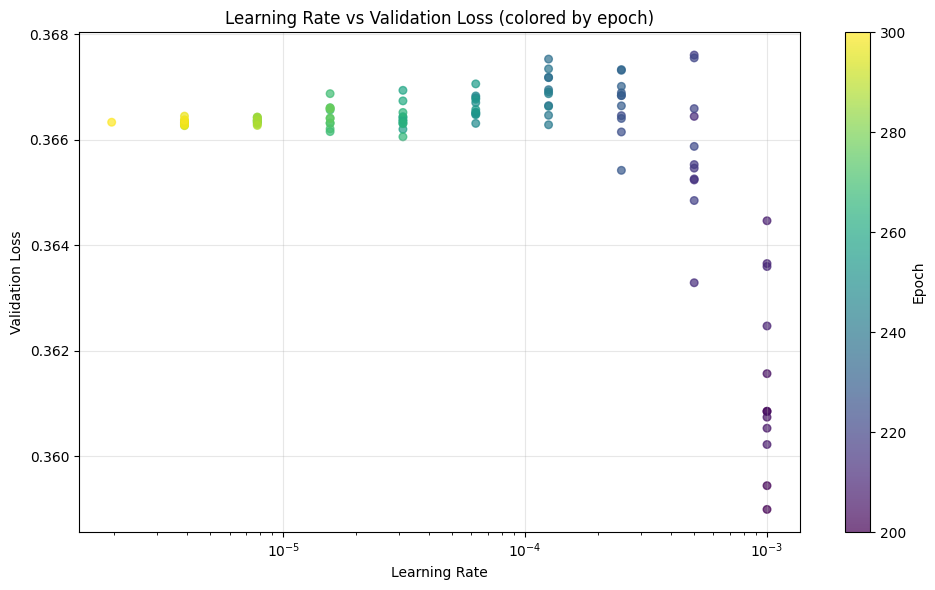

In [8]:
# Learning rate vs loss correlation
fig, ax = plt.subplots(1, 1, figsize=(10, 6))

# Create scatter plot with color gradient
scatter = ax.scatter(training_df['learning_rate'], training_df['val_loss'], 
                    c=training_df['epoch'], cmap='viridis', alpha=0.7, s=30)
ax.set_xlabel('Learning Rate')
ax.set_ylabel('Validation Loss')
ax.set_xscale('log')
ax.set_title('Learning Rate vs Validation Loss (colored by epoch)')
ax.grid(True, alpha=0.3)

# Add colorbar
cbar = plt.colorbar(scatter)
cbar.set_label('Epoch')

plt.tight_layout()
plt.show()

In [10]:
# Resume model from checkpoint
state_dict = torch.load(f'{checkpoint_path}/model_epoch_250.pth')

model = DeepFlyBrain(config=config).to(device)
model.load_state_dict(state_dict)

<All keys matched successfully>

In [11]:
# Resume dataset and dataloaders from saved indices
batch_size = 64
dataset = TopicDataset(config=config['dataset'])

with open(f'{checkpoint_path}/test_indices.txt', 'r') as f:
    test_indices = [int(line.strip()) for line in f.readlines()]
test_dataset = torch.utils.data.Subset(dataset, test_indices)

dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False, num_workers=1)  # Entire dataset
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=1)  # Test dataset

In [12]:
# Loss function
# Label smoothing loss to prevent overconfident predictions
class LabelSmoothingBCELoss(nn.Module):
    def __init__(self, smoothing=0.1):
        super().__init__()
        self.smoothing = smoothing
        self.bce = nn.BCEWithLogitsLoss()
    
    def forward(self, pred, target):
        # Apply label smoothing: y_smooth = y * (1-α) + α/2
        target_smooth = target * (1 - self.smoothing) + 0.5 * self.smoothing
        return self.bce(pred, target_smooth)

loss_fn = LabelSmoothingBCELoss(smoothing=0.1)

In [13]:
# Evaluate model on entire dataset
model.eval()

loss, correct = 0, 0
all_test_probs = []
all_test_targets = []

with torch.no_grad():
    for batch in dataloader:
        X, y = batch['sequence'], batch['label']
        X, y = X.to(device), y.to(device)
        y = y.float()
        
        pred = model(X)
        prob = torch.sigmoid(pred)
        loss += loss_fn(pred, y).item()
        
        all_test_probs.append(prob)
        all_test_targets.append(y)
        
        # Exact match accuracy
        pred_binary = (prob > 0.5).float()
        exact_match = ((pred_binary == y).sum(dim=1) == y.shape[1]).float().sum().item()
        correct += exact_match

all_test_probs = torch.cat(all_test_probs, dim=0)
all_test_targets = torch.cat(all_test_targets, dim=0)

loss /= len(dataloader)
exact_acc = correct / len(dataset)

pred_binary = (all_test_probs > 0.5).float()
hamming_acc = (pred_binary == all_test_targets).float().mean().item()

In [14]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import roc_curve, auc, precision_recall_curve, f1_score, confusion_matrix

In [15]:
# Convert PyTorch tensors to numpy for sklearn
y_pred_np = all_test_probs.cpu().numpy()
y_test_np = all_test_targets.cpu().numpy()

print("Prediction min/max:", np.min(y_pred_np), np.max(y_pred_np))
print("Prediction shape:", y_pred_np.shape)
print("Target shape:", y_test_np.shape)

Prediction min/max: 0.00376972 0.9987721
Prediction shape: (30179, 18)
Target shape: (30179, 18)


In [16]:
# Class distribution analysis
print("\nClass distribution (fraction of positives per topic):")
class_means = np.mean(y_test_np, axis=0)
for i, mean_val in enumerate(class_means):
    print(f"Topic {i}: {mean_val:.4f}")


Class distribution (fraction of positives per topic):
Topic 0: 0.0663
Topic 1: 0.0662
Topic 2: 0.0663
Topic 3: 0.0663
Topic 4: 0.0663
Topic 5: 0.0663
Topic 6: 0.0663
Topic 7: 0.0663
Topic 8: 0.0662
Topic 9: 0.0663
Topic 10: 0.0663
Topic 11: 0.0663
Topic 12: 0.0663
Topic 13: 0.0663
Topic 14: 0.0662
Topic 15: 0.0663
Topic 16: 0.0663
Topic 17: 0.0663


In [17]:
# Confusion matrix for each topic
print("\nConfusion matrices for each topic:")
for i in range(y_test_np.shape[1]):
    print(f"\nTopic {i}:")
    cm = confusion_matrix(y_test_np[:, i], y_pred_np[:, i] > 0.5)
    print(cm)


Confusion matrices for each topic:

Topic 0:
[[28057   122]
 [  596  1404]]

Topic 1:
[[28066   114]
 [  639  1360]]

Topic 2:
[[28136    43]
 [  654  1346]]

Topic 3:
[[28113    66]
 [  656  1344]]

Topic 4:
[[28050   129]
 [  684  1316]]

Topic 5:
[[28147    32]
 [  644  1356]]

Topic 6:
[[28078   101]
 [  649  1351]]

Topic 7:
[[28061   118]
 [  600  1400]]

Topic 8:
[[28119    61]
 [  718  1281]]

Topic 9:
[[28127    52]
 [  698  1302]]

Topic 10:
[[28094    85]
 [  696  1304]]

Topic 11:
[[28117    62]
 [  730  1270]]

Topic 12:
[[28126    53]
 [  648  1352]]

Topic 13:
[[28055   124]
 [  602  1398]]

Topic 14:
[[28114    66]
 [  627  1372]]

Topic 15:
[[28146    33]
 [  681  1319]]

Topic 16:
[[28100    79]
 [  652  1348]]

Topic 17:
[[28118    61]
 [  632  1368]]



Evaluating 18 topics...
Evaluating topic 0
Topic 0 - auROC: 0.9153, auPR: 0.7959, F1: 0.7964


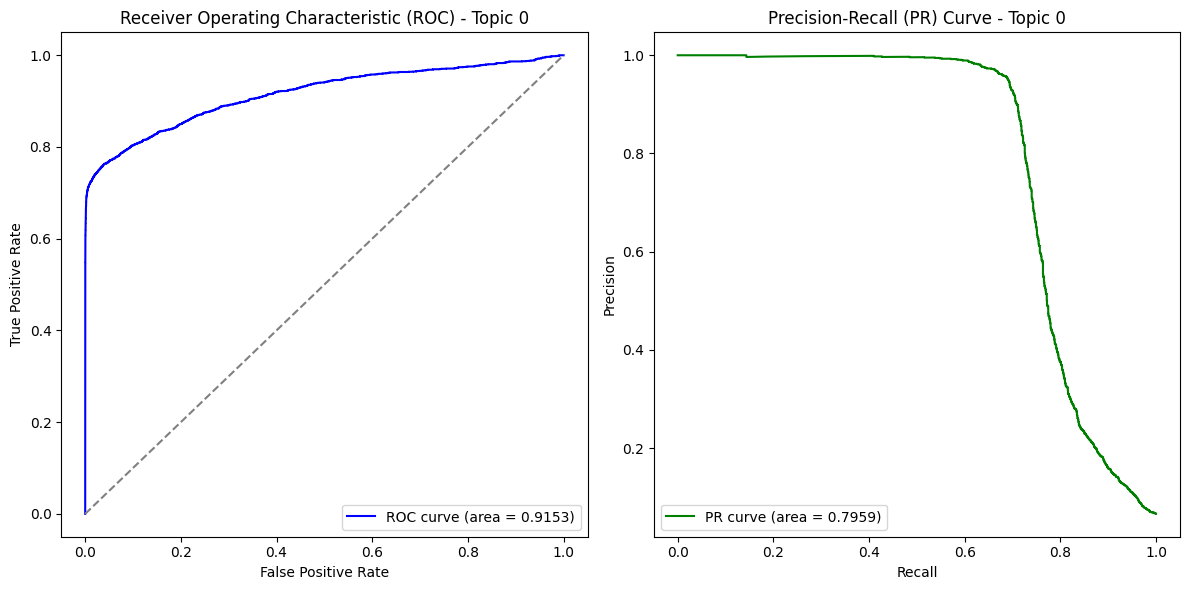

Evaluating topic 1
Topic 1 - auROC: 0.9181, auPR: 0.7918, F1: 0.7832


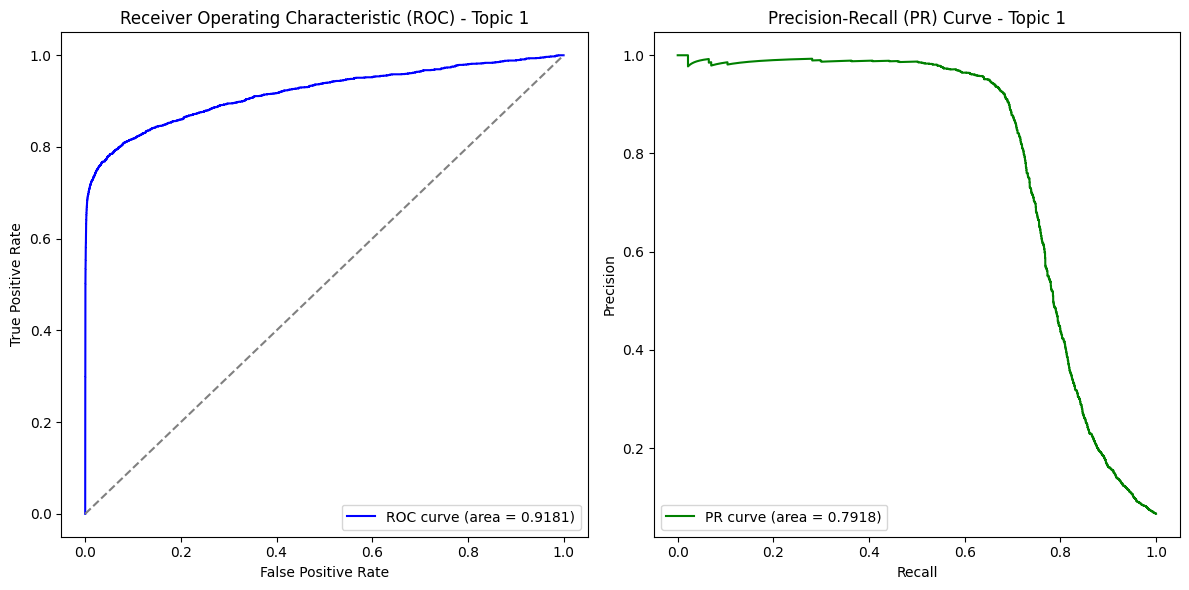

Evaluating topic 2
Topic 2 - auROC: 0.8948, auPR: 0.7759, F1: 0.7943


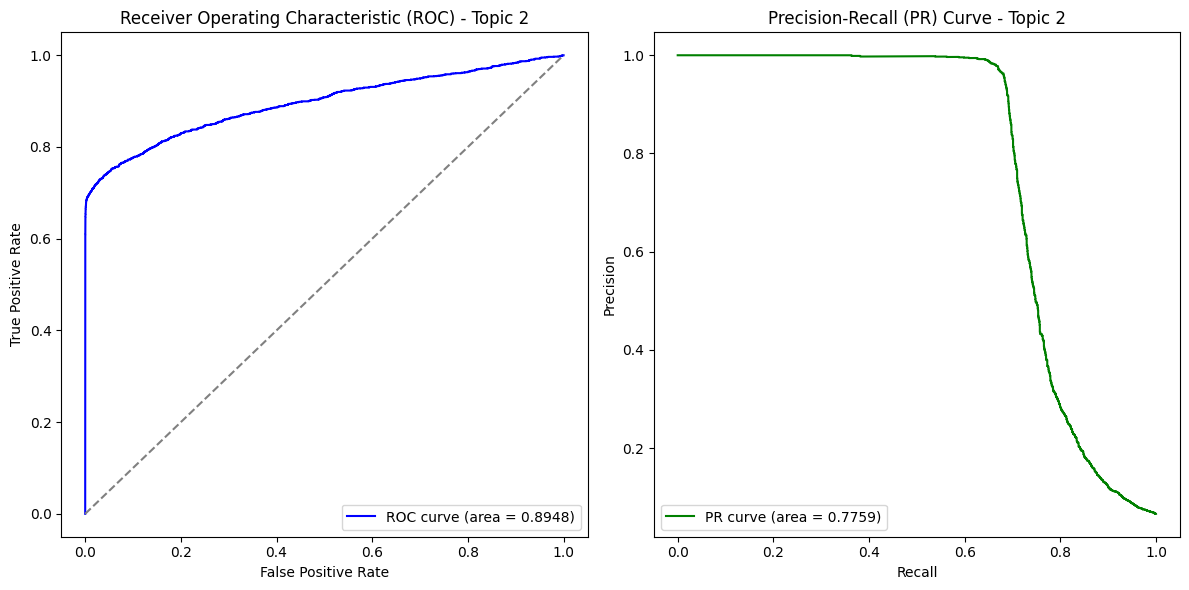

Evaluating topic 3
Topic 3 - auROC: 0.8979, auPR: 0.7790, F1: 0.7883


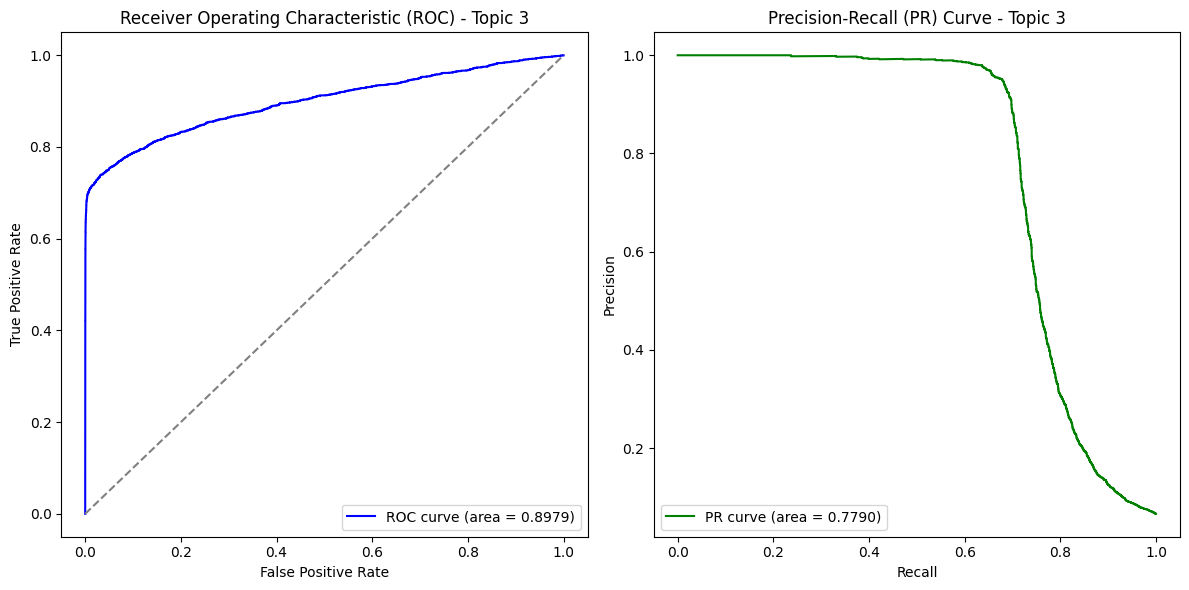

Evaluating topic 4
Topic 4 - auROC: 0.9074, auPR: 0.7803, F1: 0.7640


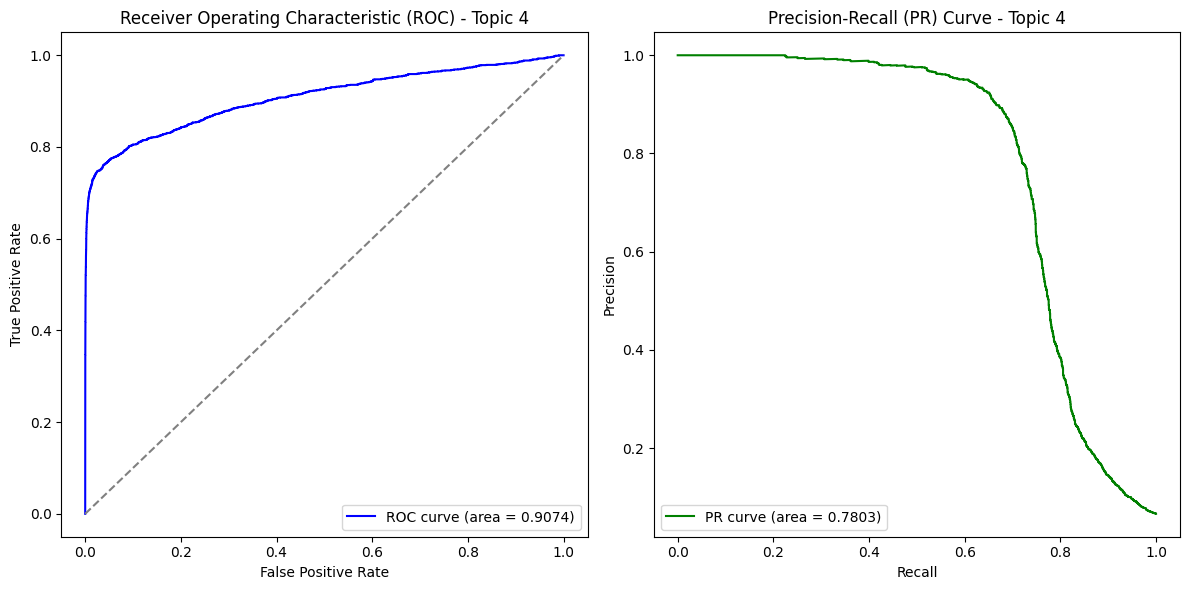

Evaluating topic 5
Topic 5 - auROC: 0.8981, auPR: 0.7816, F1: 0.8005


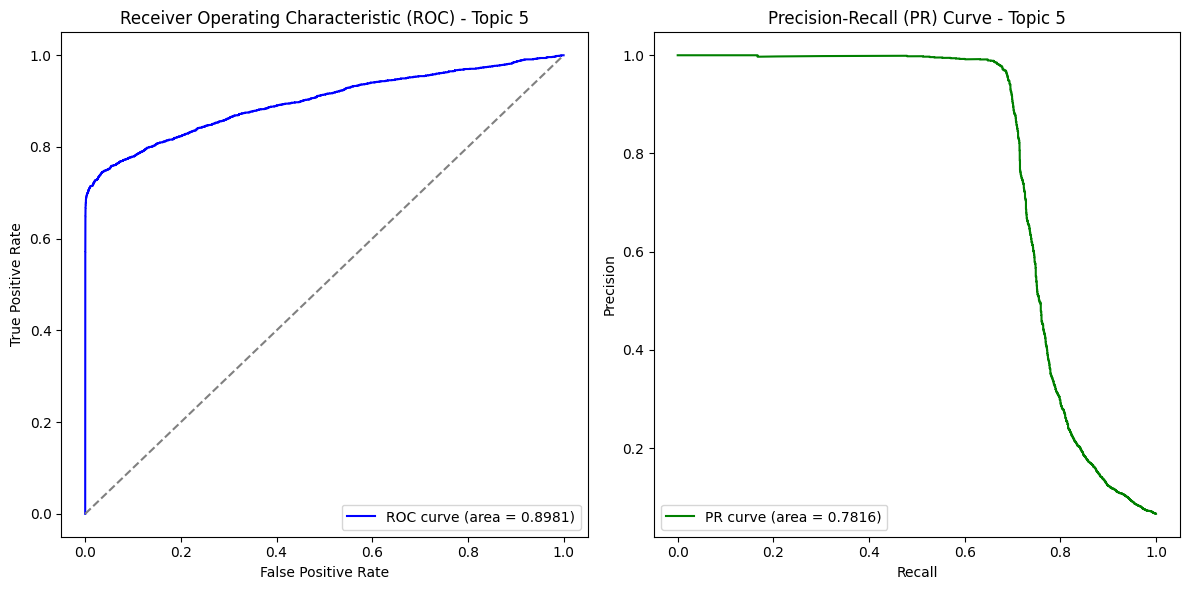

Evaluating topic 6
Topic 6 - auROC: 0.9047, auPR: 0.7770, F1: 0.7827


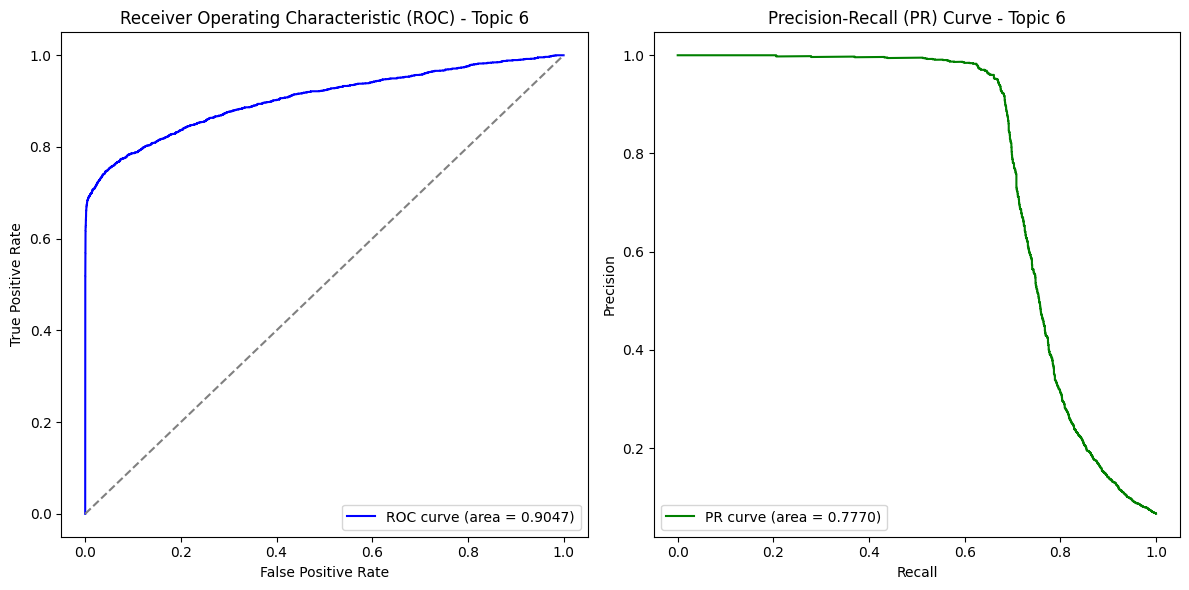

Evaluating topic 7
Topic 7 - auROC: 0.9018, auPR: 0.7801, F1: 0.7959


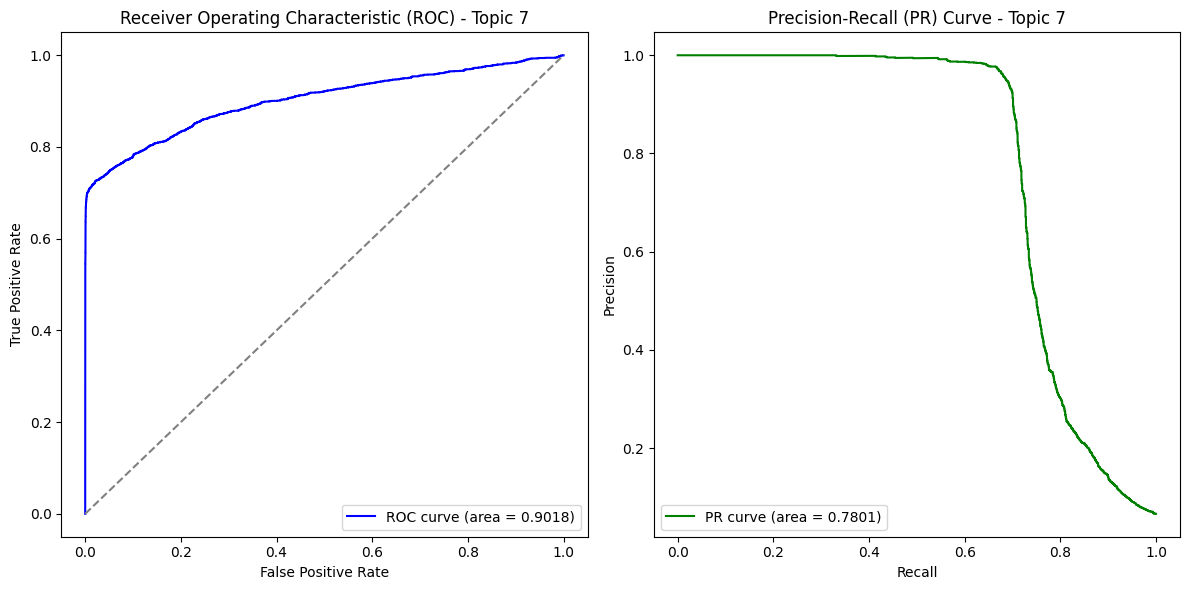

Evaluating topic 8
Topic 8 - auROC: 0.8890, auPR: 0.7662, F1: 0.7668


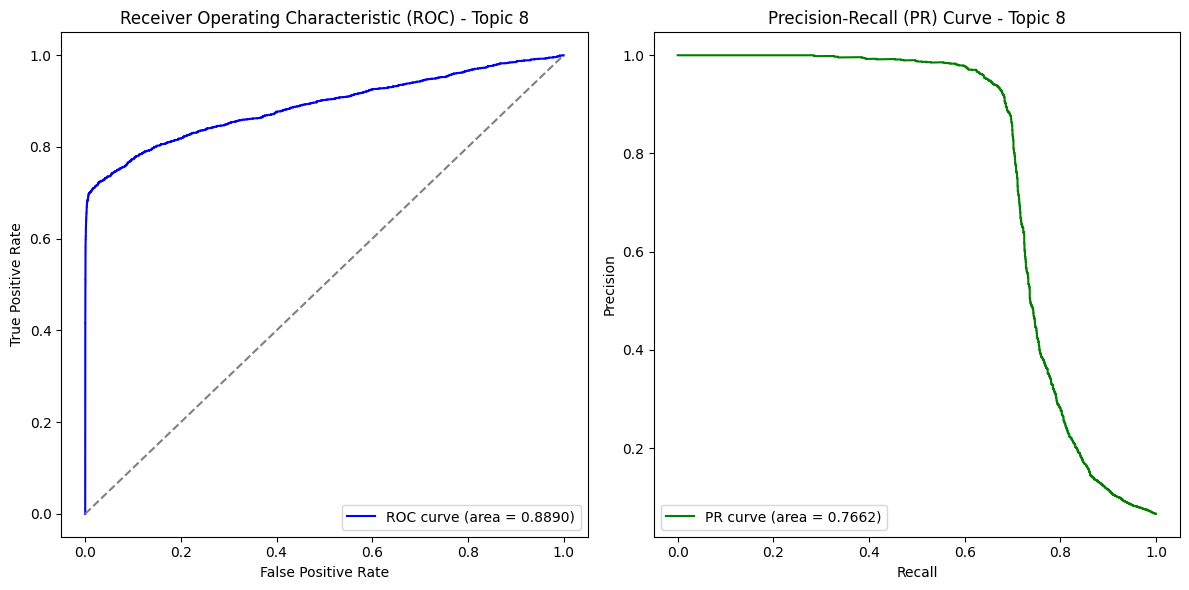

Evaluating topic 9
Topic 9 - auROC: 0.8958, auPR: 0.7769, F1: 0.7764


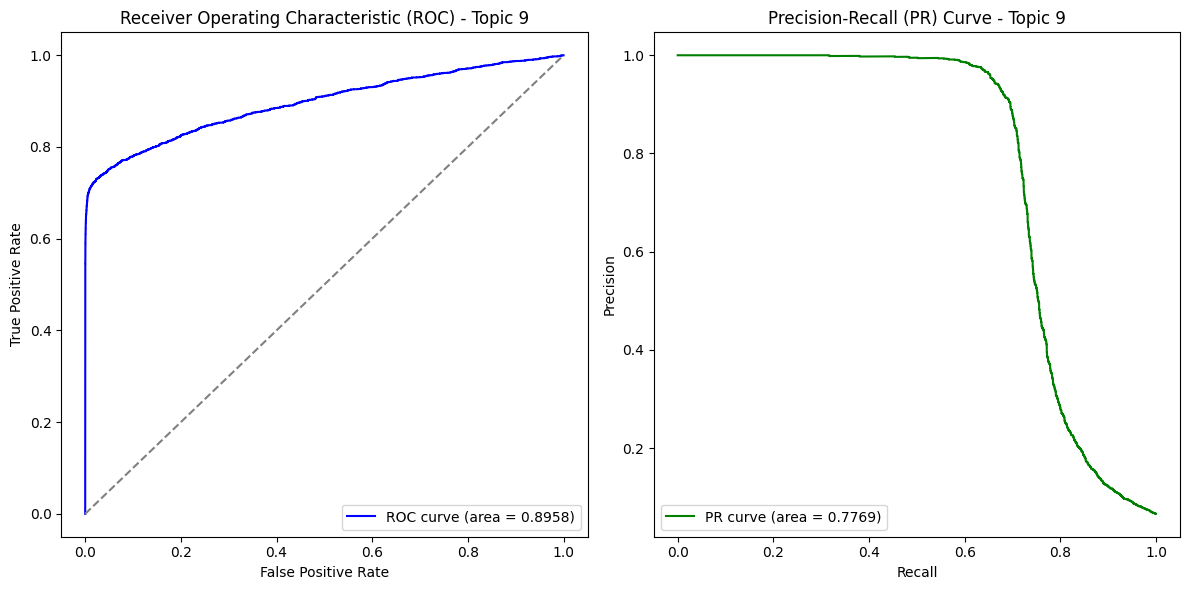

Evaluating topic 10
Topic 10 - auROC: 0.8986, auPR: 0.7755, F1: 0.7695


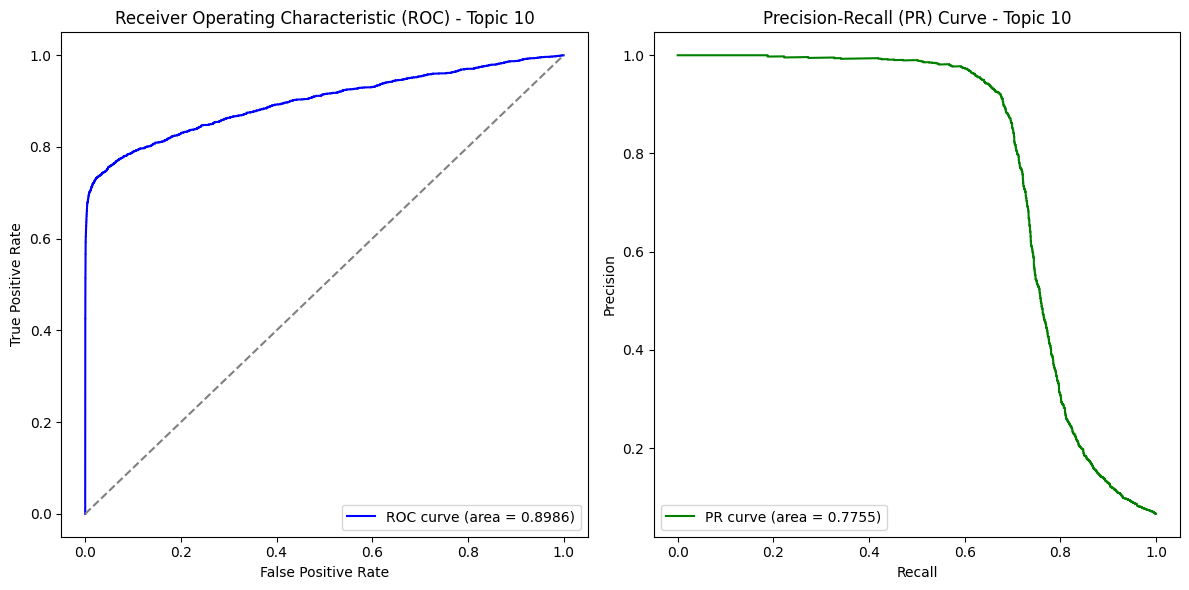

Evaluating topic 11
Topic 11 - auROC: 0.8974, auPR: 0.7715, F1: 0.7623


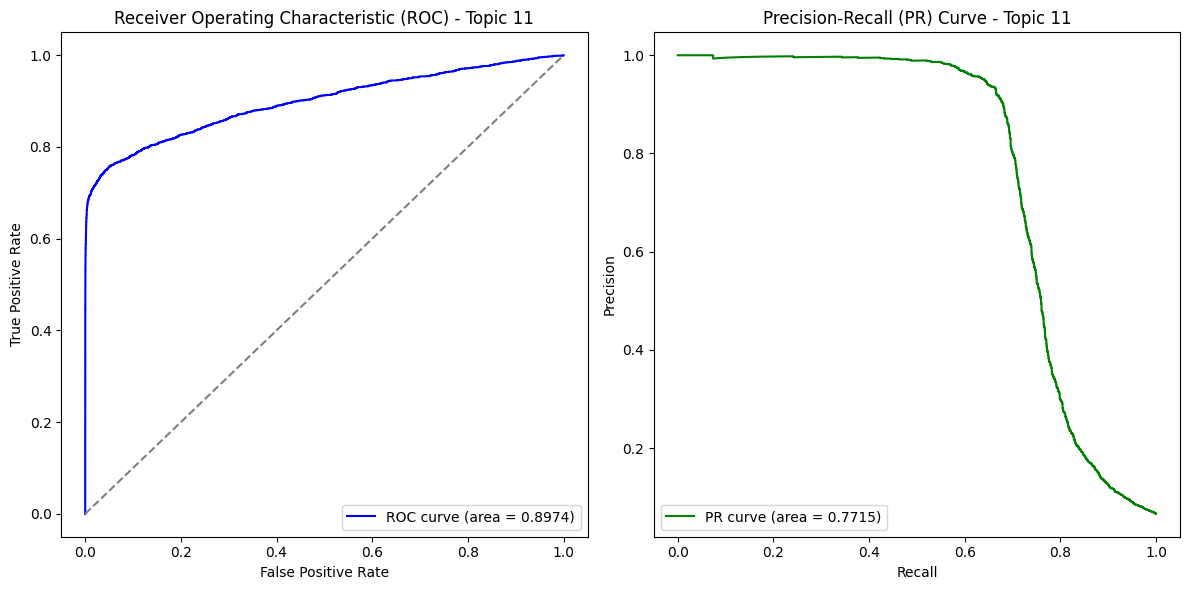

Evaluating topic 12
Topic 12 - auROC: 0.8979, auPR: 0.7809, F1: 0.7941


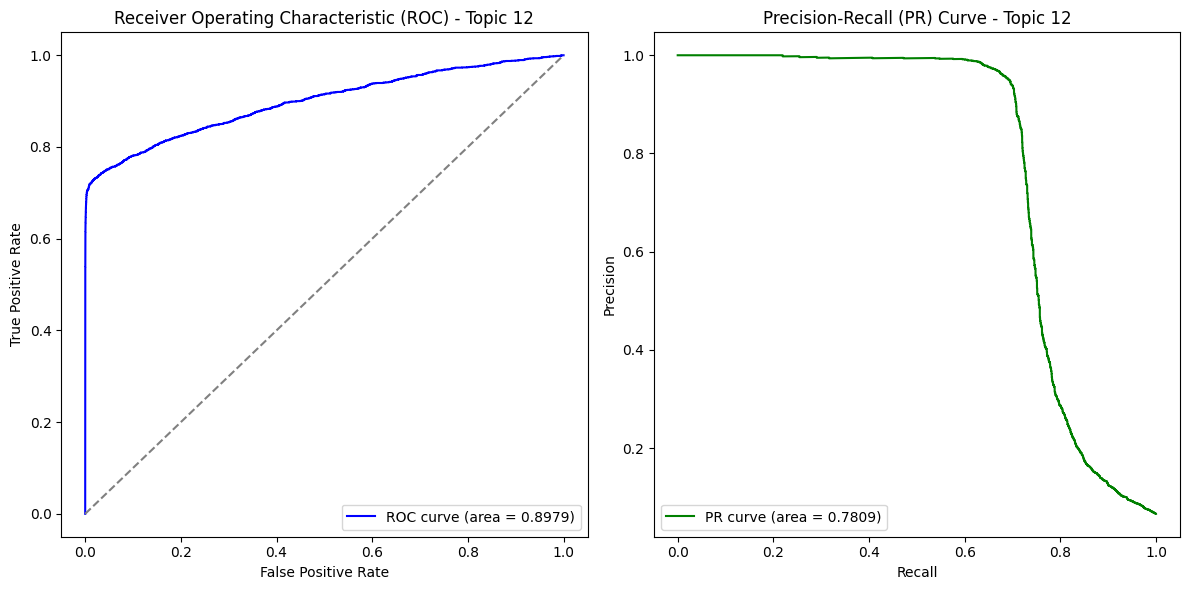

Evaluating topic 13
Topic 13 - auROC: 0.9189, auPR: 0.7917, F1: 0.7939


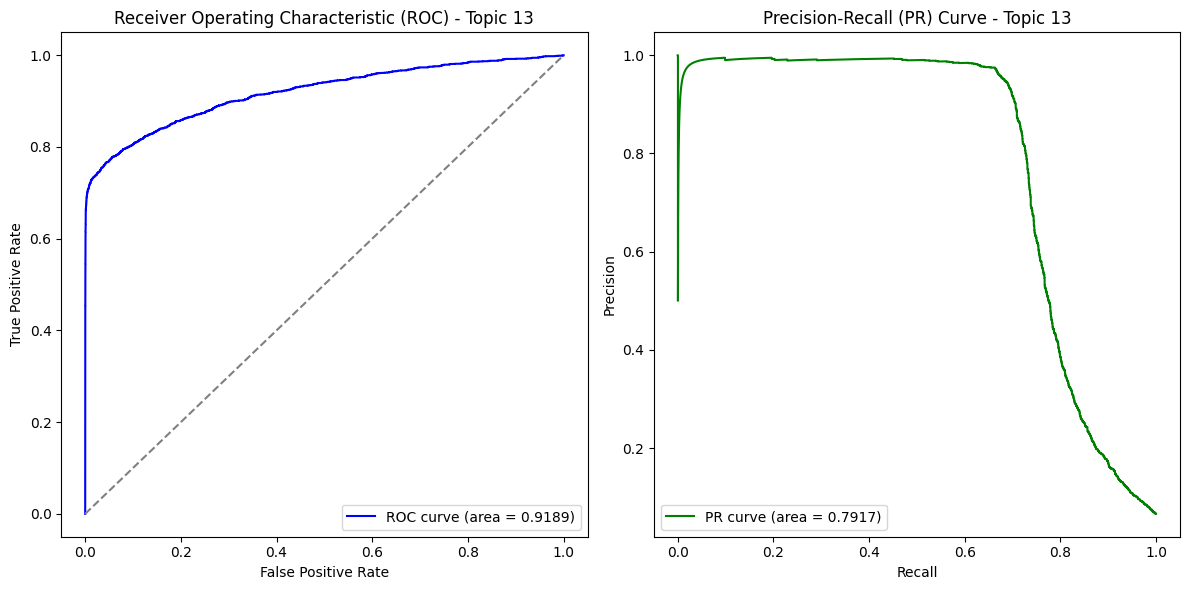

Evaluating topic 14
Topic 14 - auROC: 0.9110, auPR: 0.8004, F1: 0.7984


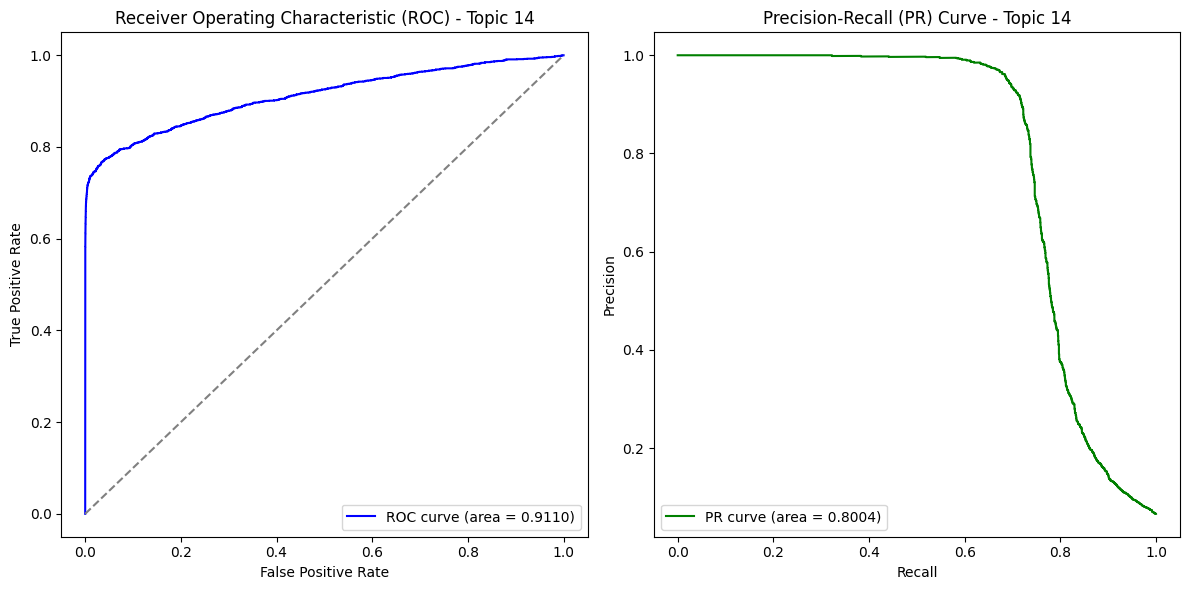

Evaluating topic 15
Topic 15 - auROC: 0.8999, auPR: 0.7790, F1: 0.7870


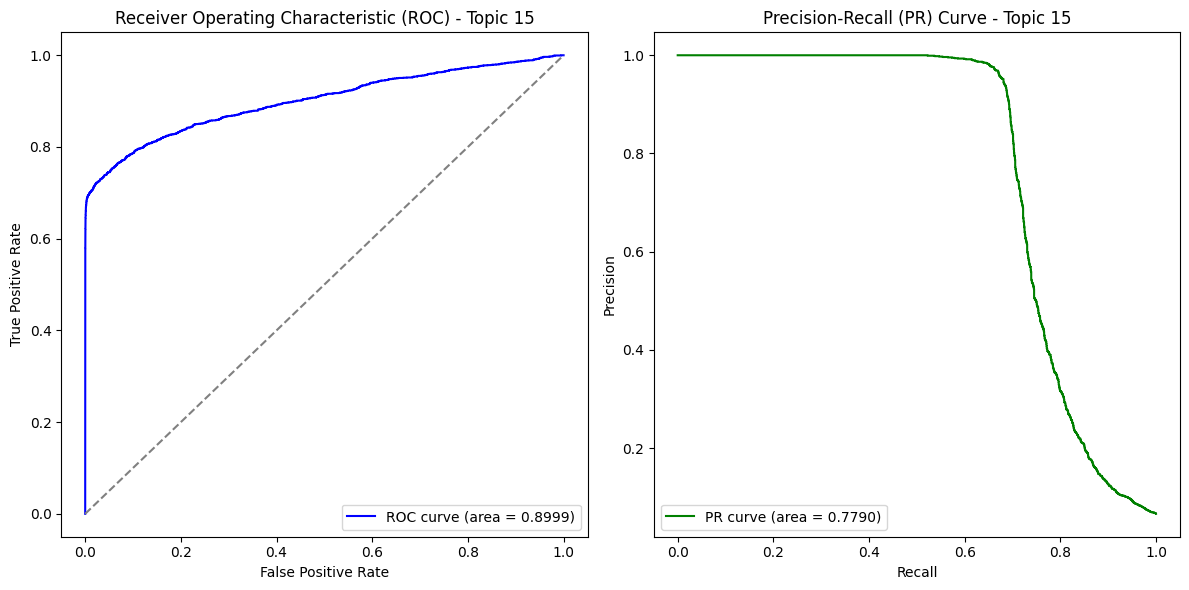

Evaluating topic 16
Topic 16 - auROC: 0.9065, auPR: 0.7836, F1: 0.7867


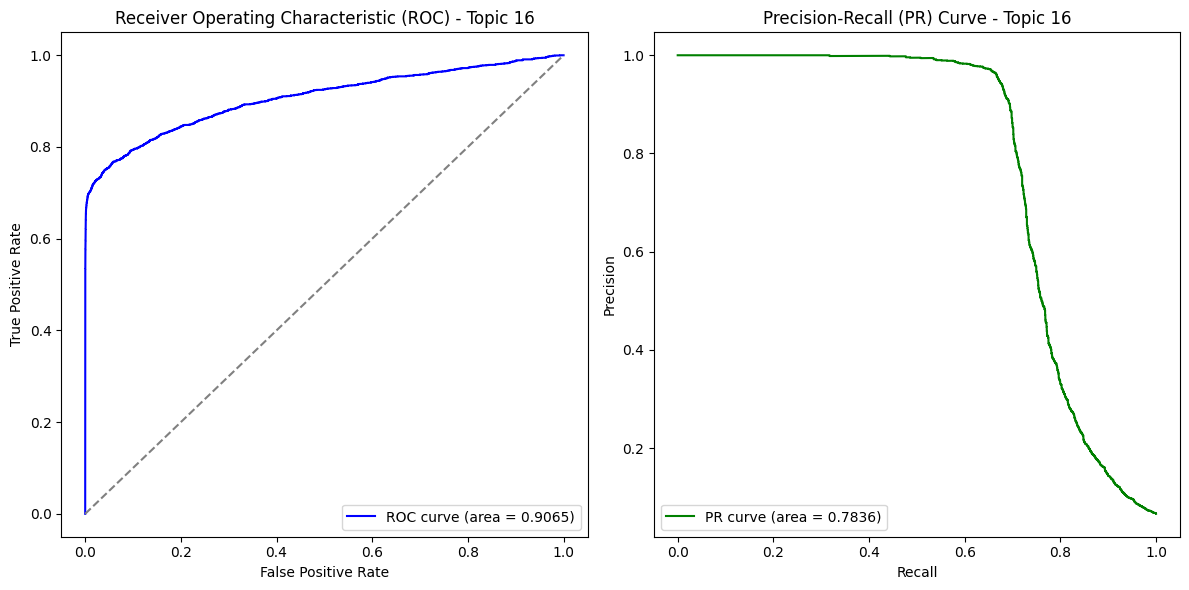

Evaluating topic 17
Topic 17 - auROC: 0.9031, auPR: 0.7858, F1: 0.7979


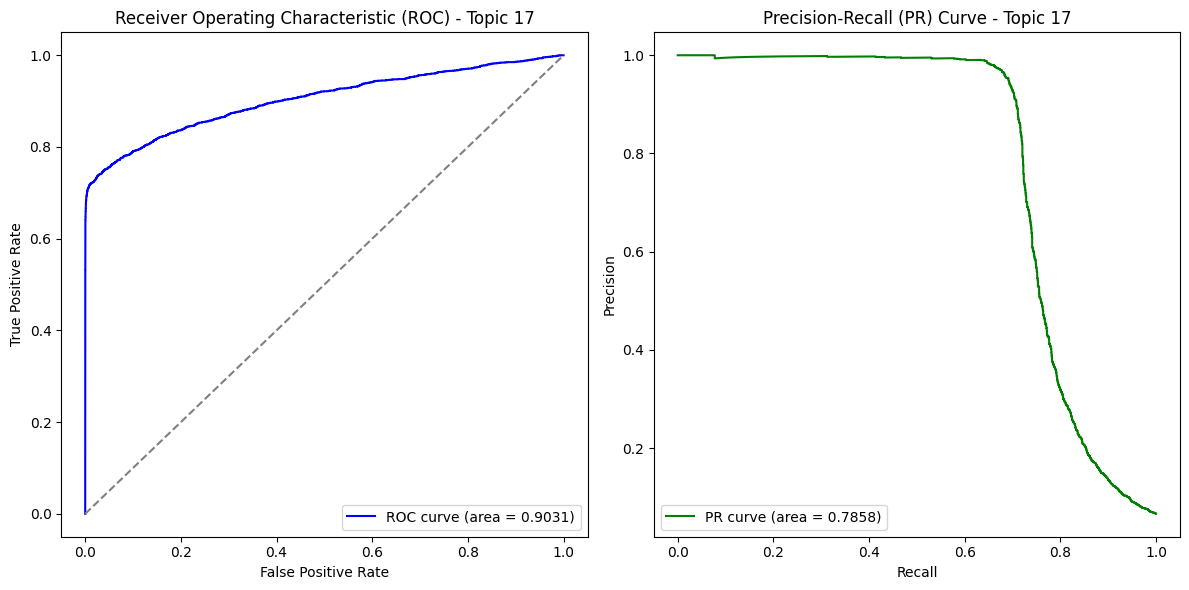

In [18]:
# Evaluate model performance for each topic
num_topics = y_test_np.shape[1]
auroc_values = []
aupr_values = []
f1_scores = []

print(f"\nEvaluating {num_topics} topics...")

for topic_idx in range(num_topics):
    print(f'Evaluating topic {topic_idx}')
    
    # Calculate ROC and PR metrics for the current topic
    fpr, tpr, _ = roc_curve(y_test_np[:, topic_idx], y_pred_np[:, topic_idx])
    roc_auc = auc(fpr, tpr)
    auroc_values.append(roc_auc)
    
    precision, recall, _ = precision_recall_curve(y_test_np[:, topic_idx], y_pred_np[:, topic_idx])
    pr_auc = auc(recall, precision)
    aupr_values.append(pr_auc)

    # Binarize predictions for F1 score calculation
    y_pred_bin = (y_pred_np[:, topic_idx] >= 0.5).astype(int)
    f1 = f1_score(y_test_np[:, topic_idx], y_pred_bin)
    f1_scores.append(f1)
    
    print(f'Topic {topic_idx} - auROC: {roc_auc:.4f}, auPR: {pr_auc:.4f}, F1: {f1:.4f}')
    
    # Plot ROC and PR curves for the current topic
    plt.figure(figsize=(12, 6))
    
    # ROC Curve
    plt.subplot(1, 2, 1)
    plt.plot(fpr, tpr, color='blue', label=f'ROC curve (area = {roc_auc:.4f})')
    plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'Receiver Operating Characteristic (ROC) - Topic {topic_idx}')
    plt.legend(loc='lower right')
    
    # PR Curve
    plt.subplot(1, 2, 2)
    plt.plot(recall, precision, color='green', label=f'PR curve (area = {pr_auc:.4f})')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(f'Precision-Recall (PR) Curve - Topic {topic_idx}')
    plt.legend(loc='lower left')
    
    plt.tight_layout()
    plt.show()

In [19]:
# Summary statistics
print(f"\nSummary Statistics:")
print(f"Mean auROC: {np.mean(auroc_values):.4f} ± {np.std(auroc_values):.4f}")
print(f"Mean auPR: {np.mean(aupr_values):.4f} ± {np.std(aupr_values):.4f}")
print(f"Mean F1: {np.mean(f1_scores):.4f} ± {np.std(f1_scores):.4f}")
print(f"Exact Match Accuracy: {exact_acc:.4f}")
print(f"Hamming Accuracy: {hamming_acc:.4f}")


Summary Statistics:
Mean auROC: 0.9031 ± 0.0081
Mean auPR: 0.7818 ± 0.0083
Mean F1: 0.7855 ± 0.0123
Exact Match Accuracy: 0.6676
Hamming Accuracy: 0.9757


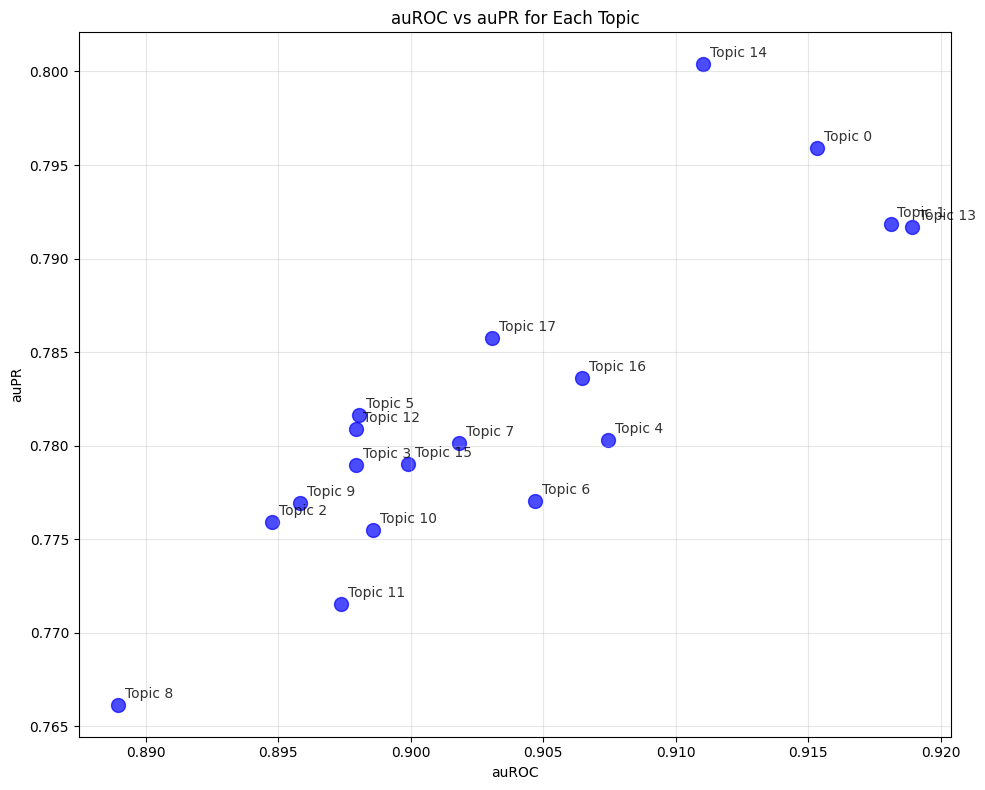

In [20]:
# Scatter plot of auROC vs auPR
plt.figure(figsize=(10, 8))
plt.scatter(auroc_values, aupr_values, color='blue', alpha=0.7, s=100, )
plt.xlabel('auROC')
plt.ylabel('auPR')
plt.title('auROC vs auPR for Each Topic')
plt.grid(True, alpha=0.3)

# Annotate each point with the topic index
for i, (x, y) in enumerate(zip(auroc_values, aupr_values)):
    plt.annotate(f'Topic {i}', (x, y), fontsize=10, alpha=0.8, 
                xytext=(5, 5), textcoords='offset points')

plt.tight_layout()
plt.show()

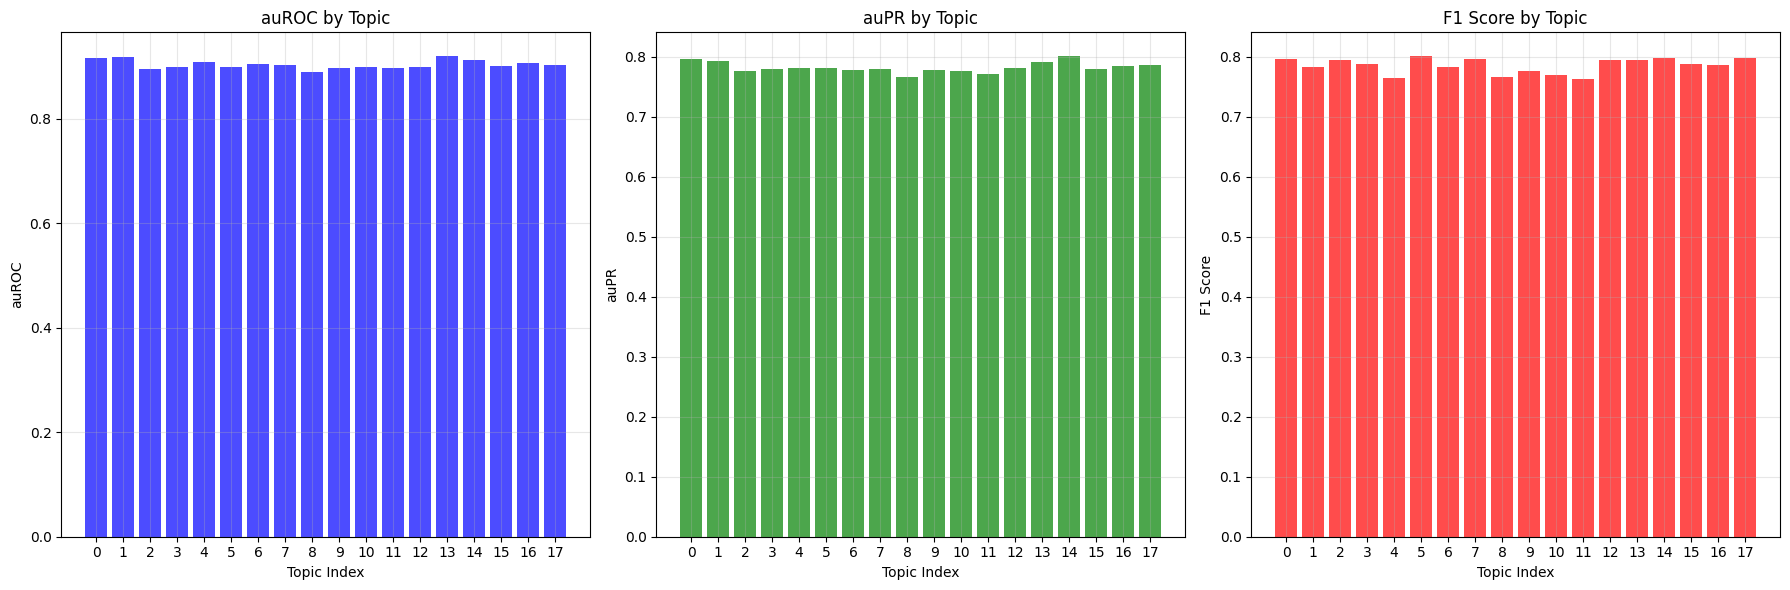

In [21]:
# Bar plots for metrics comparison
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# auROC bar plot
axes[0].bar(range(num_topics), auroc_values, color='blue', alpha=0.7)
axes[0].set_xlabel('Topic Index')
axes[0].set_ylabel('auROC')
axes[0].set_title('auROC by Topic')
axes[0].set_xticks(range(num_topics))
axes[0].grid(True, alpha=0.3)

# auPR bar plot
axes[1].bar(range(num_topics), aupr_values, color='green', alpha=0.7)
axes[1].set_xlabel('Topic Index')
axes[1].set_ylabel('auPR')
axes[1].set_title('auPR by Topic')
axes[1].set_xticks(range(num_topics))
axes[1].grid(True, alpha=0.3)

# F1 bar plot
axes[2].bar(range(num_topics), f1_scores, color='red', alpha=0.7)
axes[2].set_xlabel('Topic Index')
axes[2].set_ylabel('F1 Score')
axes[2].set_title('F1 Score by Topic')
axes[2].set_xticks(range(num_topics))
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

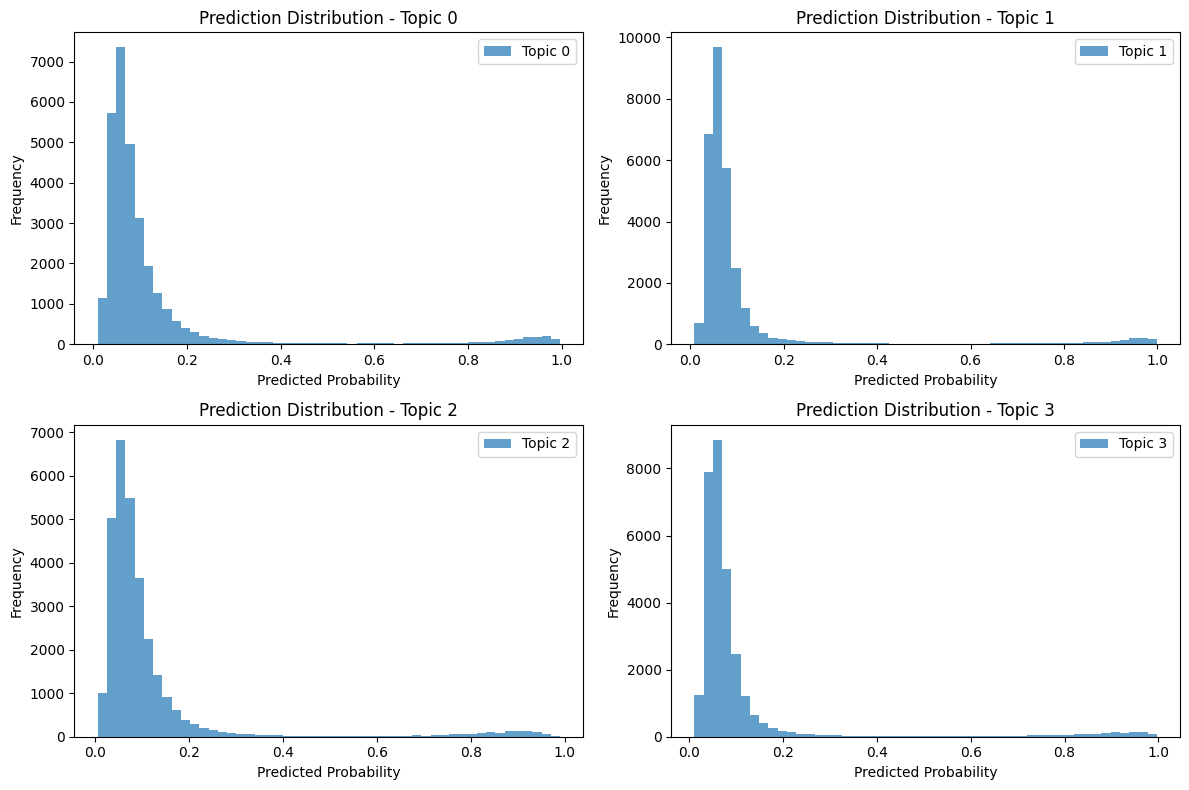


Sample predictions (first 10 samples):
Sample 0:
  Predicted: [0.09105153 0.04741944 0.04837815 0.053154   0.06017132 0.05870612
 0.05606031 0.1504689  0.10685375 0.03655501 0.07591857 0.05985059
 0.07044482 0.92182356 0.03342668 0.07873997 0.08865307 0.02231213]
  Actual:    [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
  Binary:    [0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0]

Sample 1:
  Predicted: [0.03977538 0.0358173  0.06852815 0.04012353 0.01322012 0.02933555
 0.04386068 0.0435127  0.7389043  0.05197711 0.05390592 0.9358129
 0.02620214 0.03903371 0.06575759 0.0329444  0.07051333 0.05176268]
  Actual:    [0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
  Binary:    [0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0]

Sample 2:
  Predicted: [0.0468715  0.04138158 0.04086559 0.03348598 0.26819193 0.03942776
 0.08067872 0.05312379 0.03625204 0.04800007 0.29218325 0.24856324
 0.06531295 0.06965815 0.19994035 0.09484164 0.04560176 0.05396141]
  Actual:    [0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 

In [22]:
# Additional analysis: Prediction distribution
plt.figure(figsize=(12, 8))

# Histogram of predictions for each topic
for i in range(min(4, num_topics)):  # Show first 4 topics
    plt.subplot(2, 2, i+1)
    plt.hist(y_pred_np[:, i], bins=50, alpha=0.7, label=f'Topic {i}')
    plt.xlabel('Predicted Probability')
    plt.ylabel('Frequency')
    plt.title(f'Prediction Distribution - Topic {i}')
    plt.legend()

plt.tight_layout()
plt.show()

# Sample predictions vs targets
print("\nSample predictions (first 10 samples):")
for i in range(min(10, y_pred_np.shape[0])):
    print(f"Sample {i}:")
    print(f"  Predicted: {y_pred_np[i]}")
    print(f"  Actual:    {y_test_np[i]}")
    print(f"  Binary:    {(y_pred_np[i] > 0.5).astype(int)}")
    print()

In [23]:
# Evaluate model on test dataset
model.eval()

loss, correct = 0, 0
all_test_probs = []
all_test_targets = []

with torch.no_grad():
    for batch in test_dataloader:
        X, y = batch['sequence'], batch['label']
        X, y = X.to(device), y.to(device)
        y = y.float()
        
        pred = model(X)
        prob = torch.sigmoid(pred)
        loss += loss_fn(pred, y).item()
        
        all_test_probs.append(prob)
        all_test_targets.append(y)
        
        # Exact match accuracy
        pred_binary = (prob > 0.5).float()
        exact_match = ((pred_binary == y).sum(dim=1) == y.shape[1]).float().sum().item()
        correct += exact_match

all_test_probs = torch.cat(all_test_probs, dim=0)
all_test_targets = torch.cat(all_test_targets, dim=0)

loss /= len(test_dataloader)
exact_acc = correct / len(dataset)

pred_binary = (all_test_probs > 0.5).float()
hamming_acc = (pred_binary == all_test_targets).float().mean().item()

In [24]:
# Convert PyTorch tensors to numpy for sklearn
y_pred_np = all_test_probs.cpu().numpy()
y_test_np = all_test_targets.cpu().numpy()

print("Prediction min/max:", np.min(y_pred_np), np.max(y_pred_np))
print("Prediction shape:", y_pred_np.shape)
print("Target shape:", y_test_np.shape)

Prediction min/max: 0.0054861233 0.9976521
Prediction shape: (4528, 18)
Target shape: (4528, 18)


In [25]:
# Class distribution analysis
print("\nClass distribution (fraction of positives per topic):")
class_means = np.mean(y_test_np, axis=0)
for i, mean_val in enumerate(class_means):
    print(f"Topic {i}: {mean_val:.4f}")


Class distribution (fraction of positives per topic):
Topic 0: 0.0636
Topic 1: 0.0669
Topic 2: 0.0700
Topic 3: 0.0696
Topic 4: 0.0687
Topic 5: 0.0643
Topic 6: 0.0674
Topic 7: 0.0632
Topic 8: 0.0671
Topic 9: 0.0660
Topic 10: 0.0678
Topic 11: 0.0711
Topic 12: 0.0647
Topic 13: 0.0665
Topic 14: 0.0632
Topic 15: 0.0685
Topic 16: 0.0718
Topic 17: 0.0656


In [26]:
# Confusion matrix for each topic
print("\nConfusion matrices for each topic:")
for i in range(y_test_np.shape[1]):
    print(f"\nTopic {i}:")
    cm = confusion_matrix(y_test_np[:, i], y_pred_np[:, i] > 0.5)
    print(cm)


Confusion matrices for each topic:

Topic 0:
[[4172   68]
 [ 280    8]]

Topic 1:
[[4159   66]
 [ 287   16]]

Topic 2:
[[4191   20]
 [ 312    5]]

Topic 3:
[[4181   32]
 [ 309    6]]

Topic 4:
[[4152   65]
 [ 302    9]]

Topic 5:
[[4216   21]
 [ 290    1]]

Topic 6:
[[4169   54]
 [ 298    7]]

Topic 7:
[[4171   71]
 [ 277    9]]

Topic 8:
[[4195   29]
 [ 302    2]]

Topic 9:
[[4197   32]
 [ 296    3]]

Topic 10:
[[4185   36]
 [ 303    4]]

Topic 11:
[[4179   27]
 [ 317    5]]

Topic 12:
[[4212   23]
 [ 291    2]]

Topic 13:
[[4170   57]
 [ 293    8]]

Topic 14:
[[4213   29]
 [ 281    5]]

Topic 15:
[[4203   15]
 [ 308    2]]

Topic 16:
[[4166   37]
 [ 317    8]]

Topic 17:
[[4200   31]
 [ 293    4]]



Evaluating 18 topics...
Evaluating topic 0
Topic 0 - auROC: 0.5863, auPR: 0.0834, F1: 0.0440


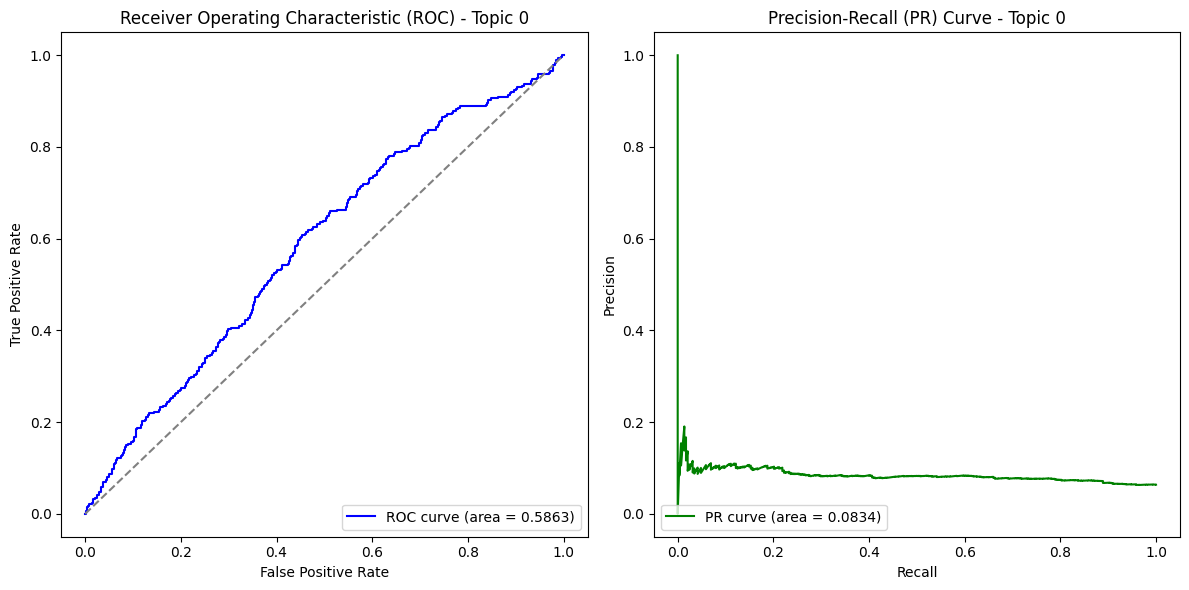

Evaluating topic 1
Topic 1 - auROC: 0.6274, auPR: 0.1221, F1: 0.0831


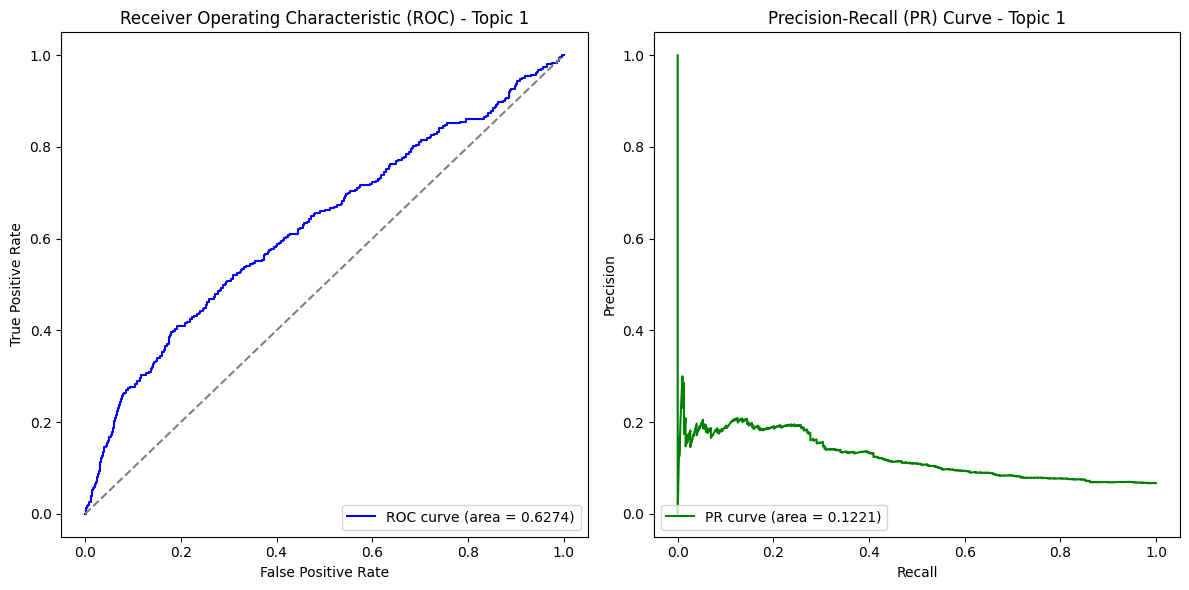

Evaluating topic 2
Topic 2 - auROC: 0.5147, auPR: 0.0801, F1: 0.0292


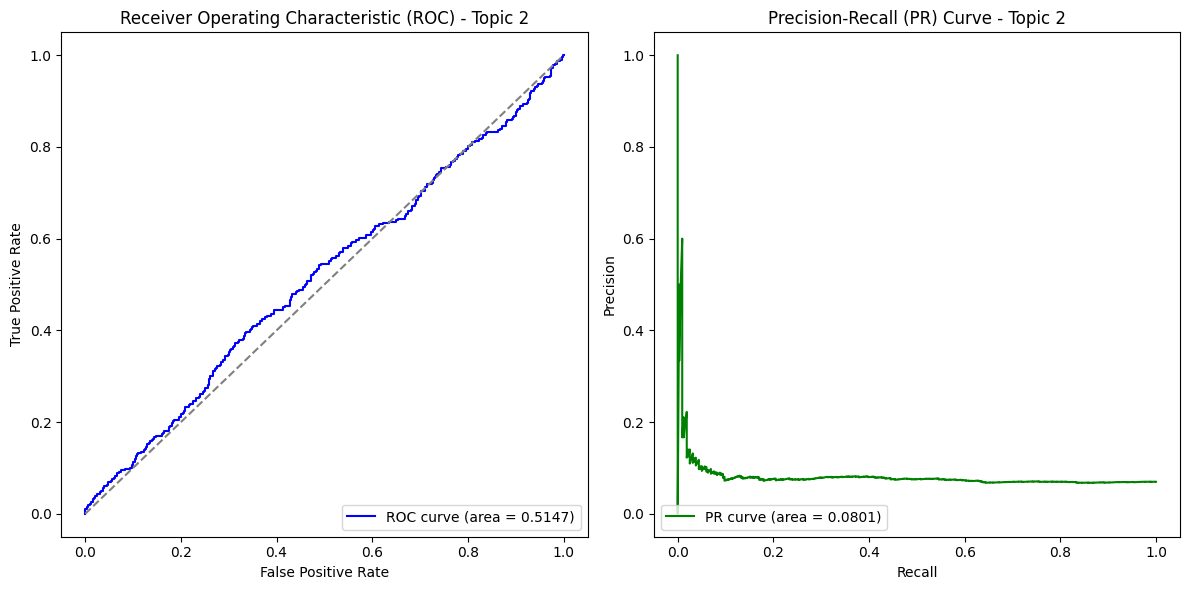

Evaluating topic 3
Topic 3 - auROC: 0.5396, auPR: 0.0908, F1: 0.0340


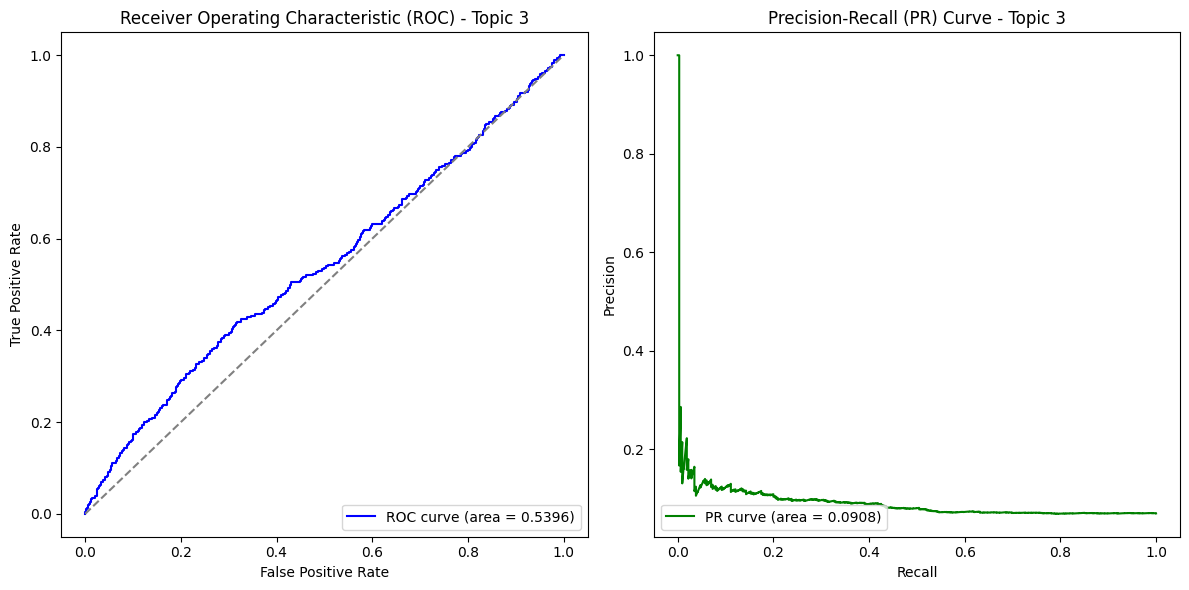

Evaluating topic 4
Topic 4 - auROC: 0.5989, auPR: 0.1066, F1: 0.0468


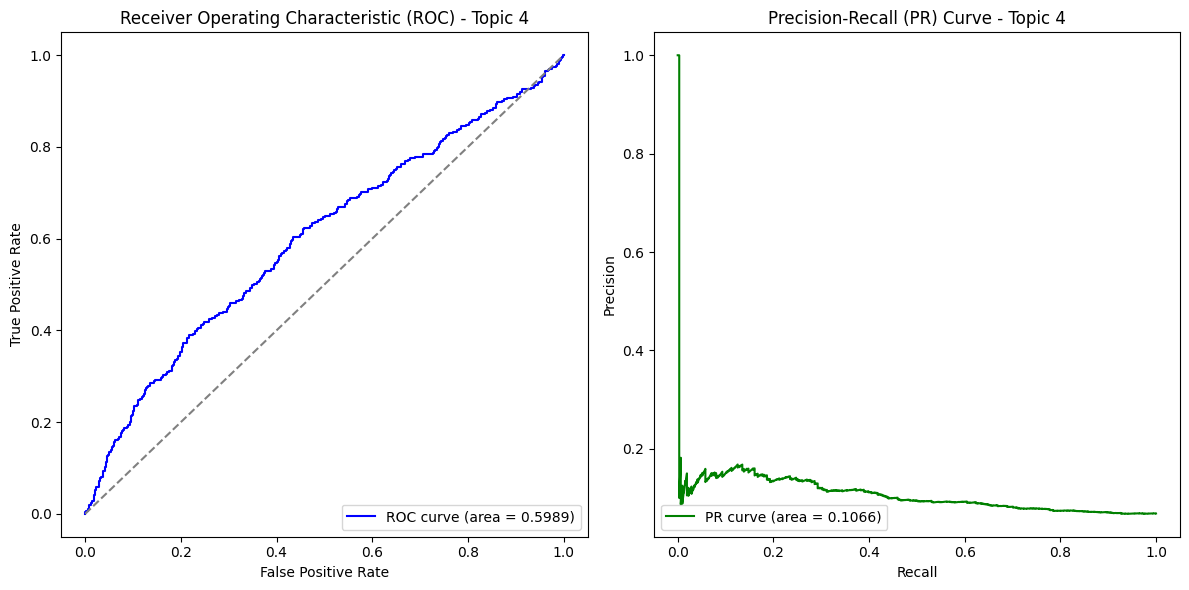

Evaluating topic 5
Topic 5 - auROC: 0.5296, auPR: 0.0683, F1: 0.0064


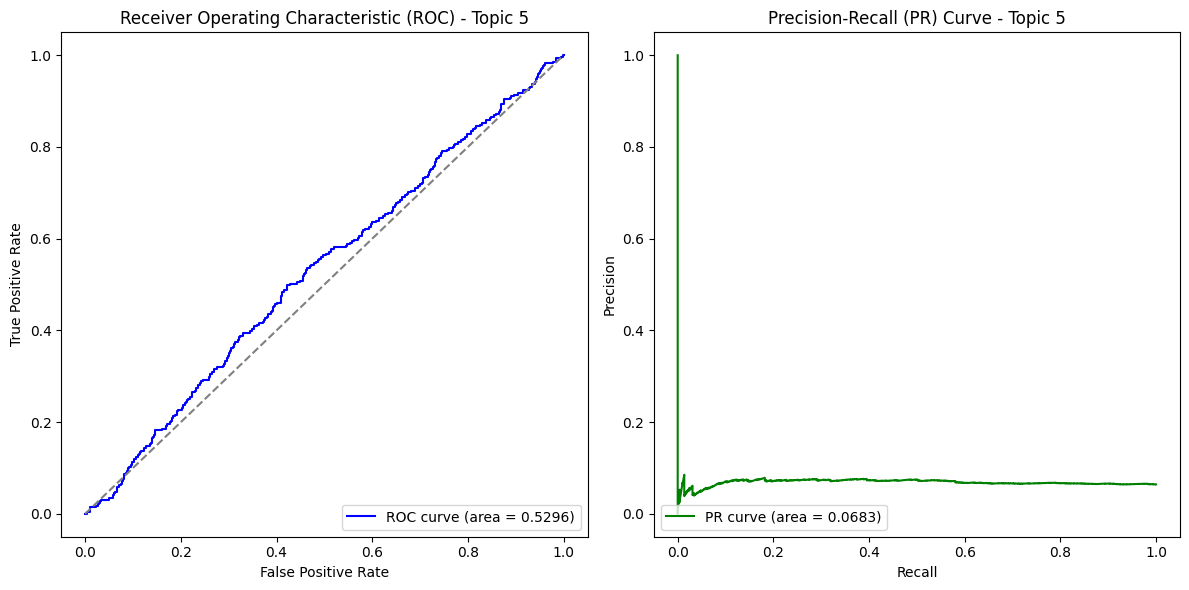

Evaluating topic 6
Topic 6 - auROC: 0.5942, auPR: 0.1003, F1: 0.0383


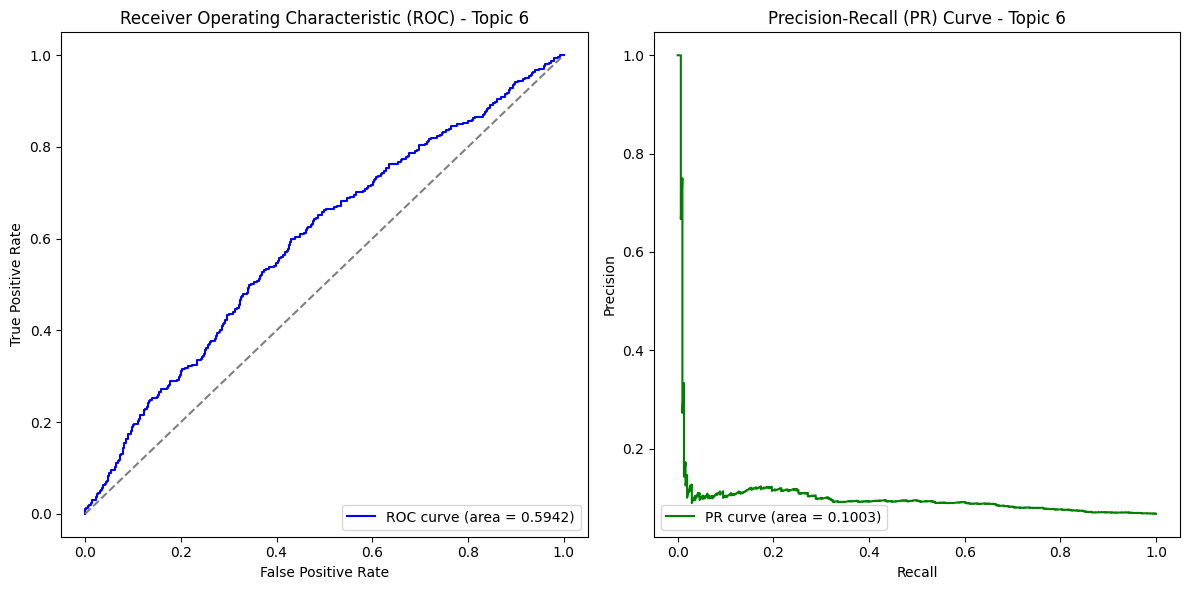

Evaluating topic 7
Topic 7 - auROC: 0.5597, auPR: 0.0757, F1: 0.0492


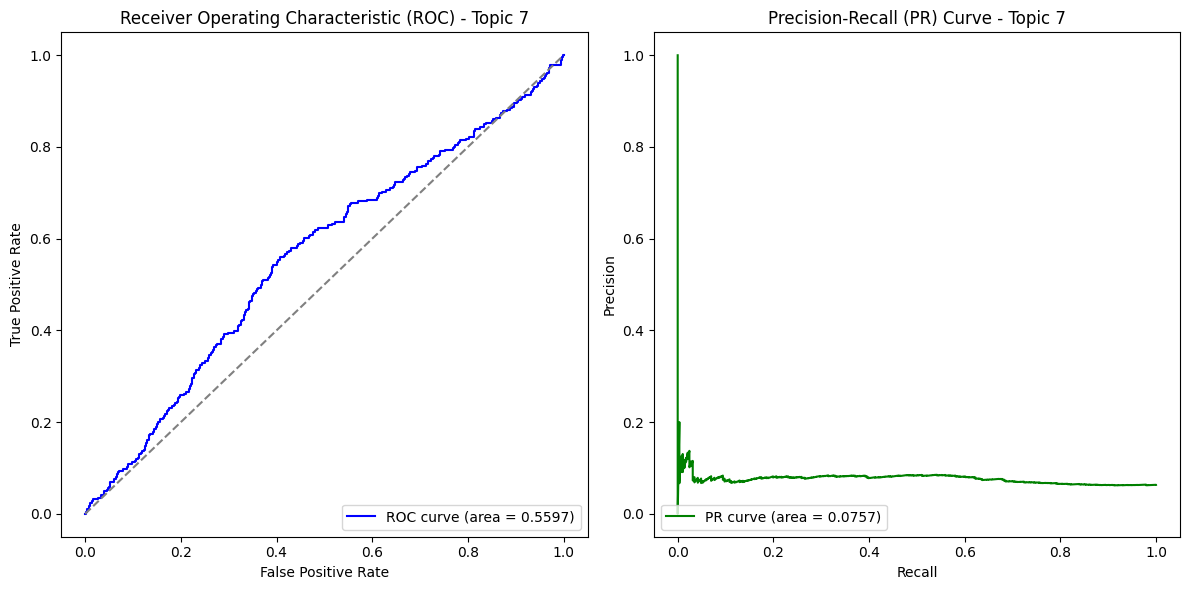

Evaluating topic 8
Topic 8 - auROC: 0.5048, auPR: 0.0743, F1: 0.0119


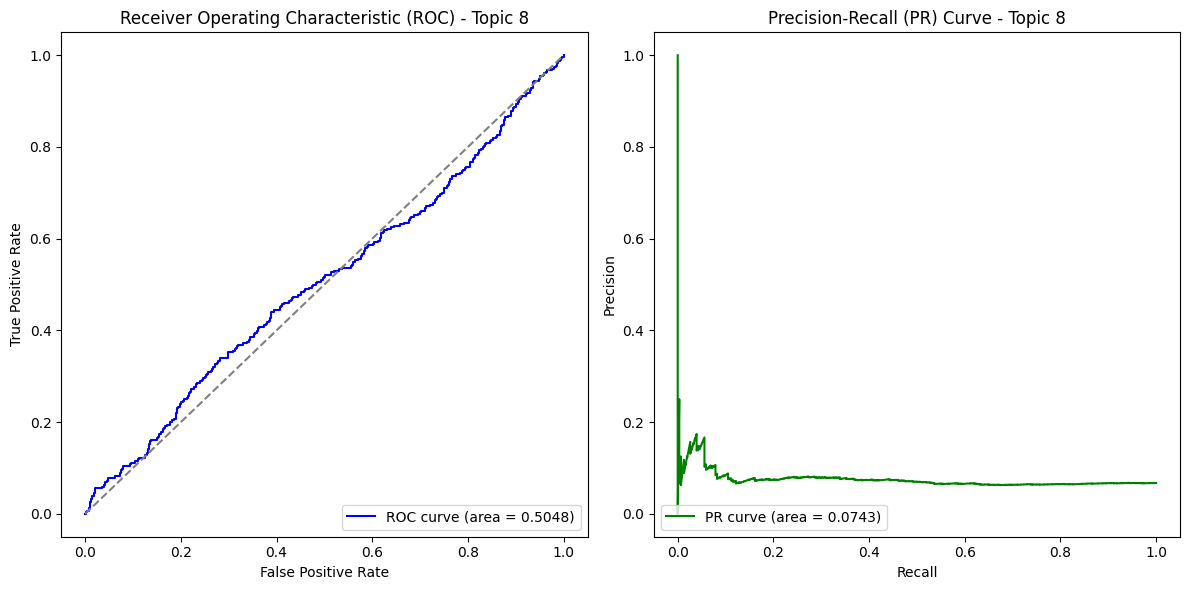

Evaluating topic 9
Topic 9 - auROC: 0.5412, auPR: 0.0788, F1: 0.0180


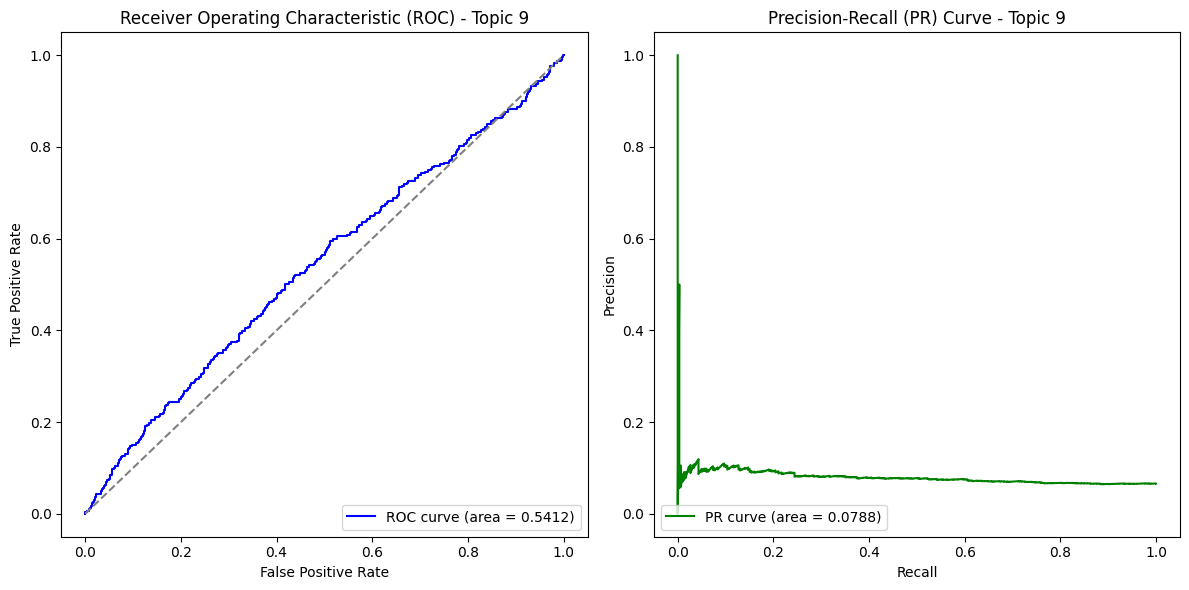

Evaluating topic 10
Topic 10 - auROC: 0.5553, auPR: 0.0852, F1: 0.0231


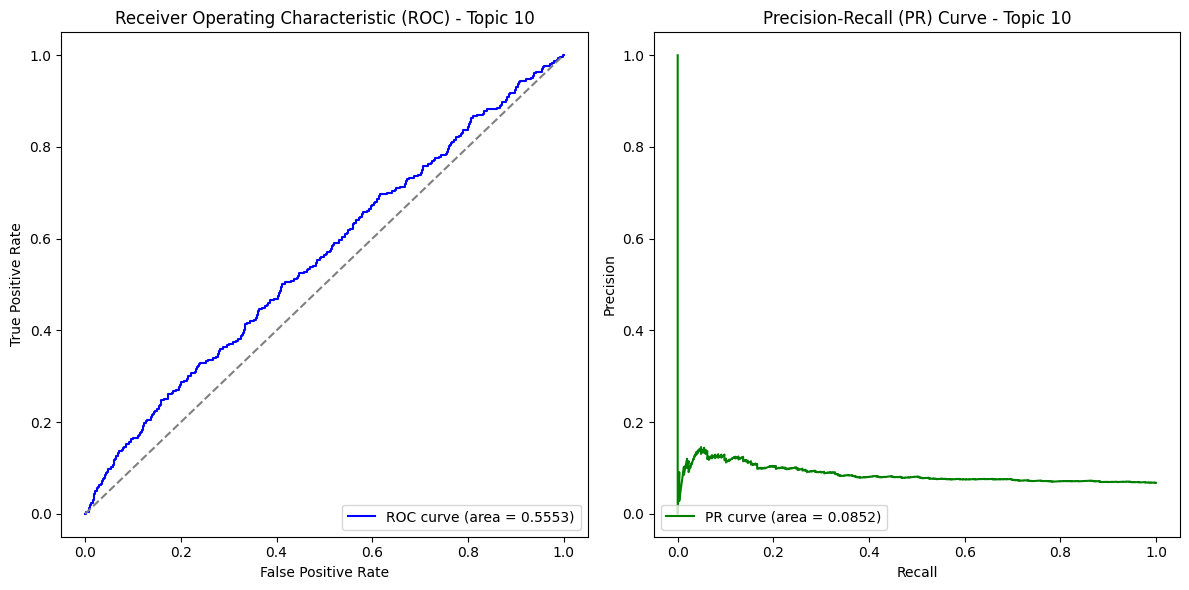

Evaluating topic 11
Topic 11 - auROC: 0.5425, auPR: 0.0956, F1: 0.0282


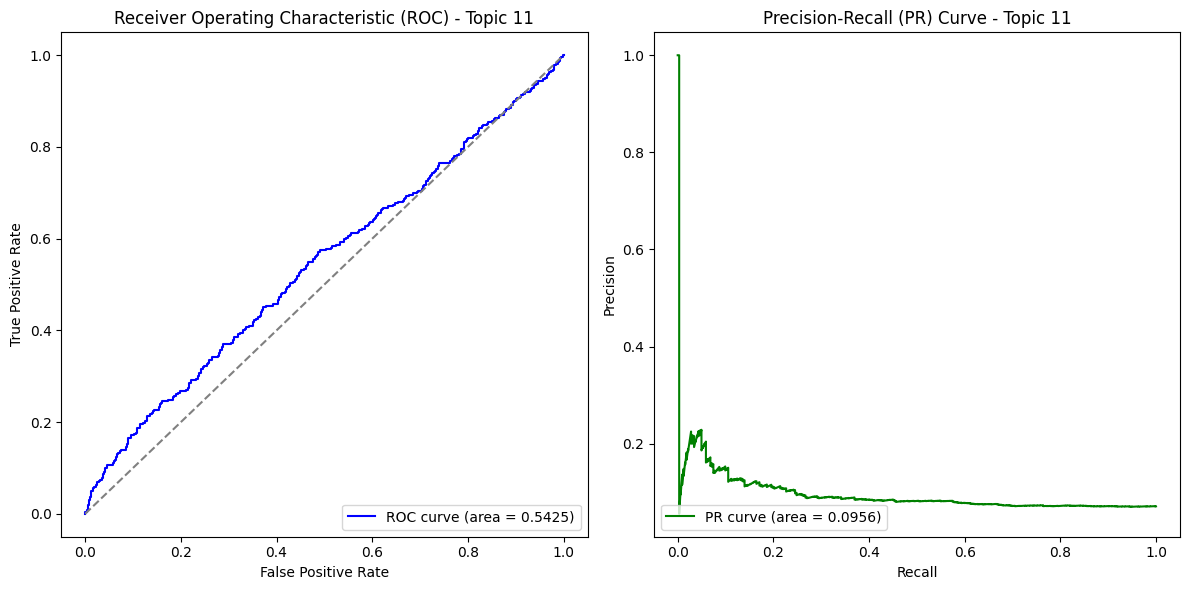

Evaluating topic 12
Topic 12 - auROC: 0.5214, auPR: 0.0681, F1: 0.0126


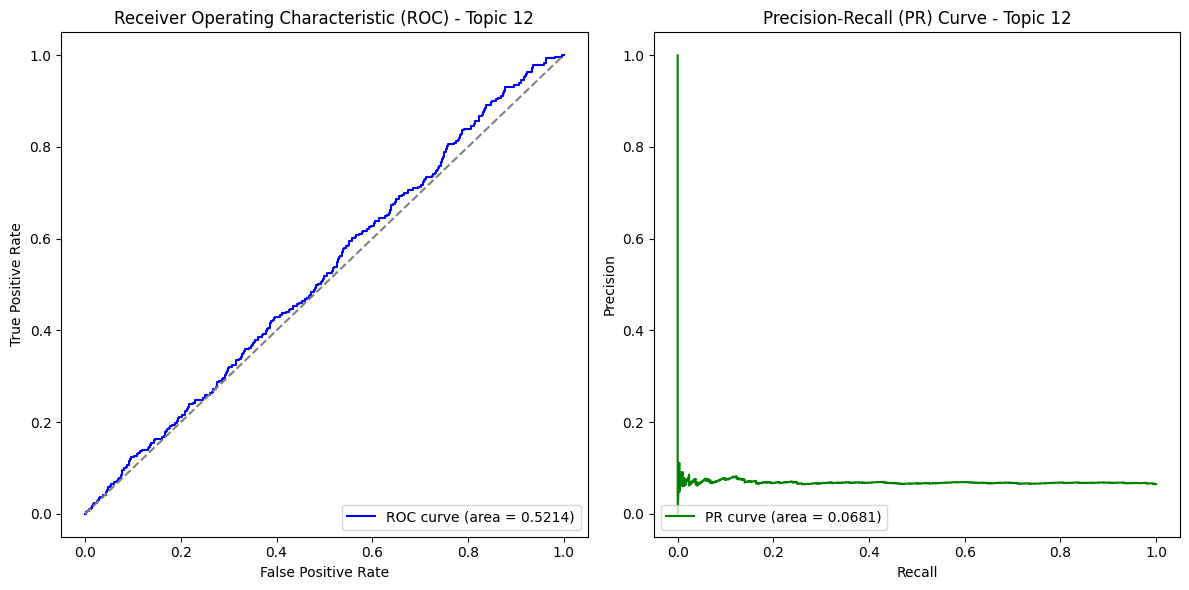

Evaluating topic 13
Topic 13 - auROC: 0.6099, auPR: 0.0957, F1: 0.0437


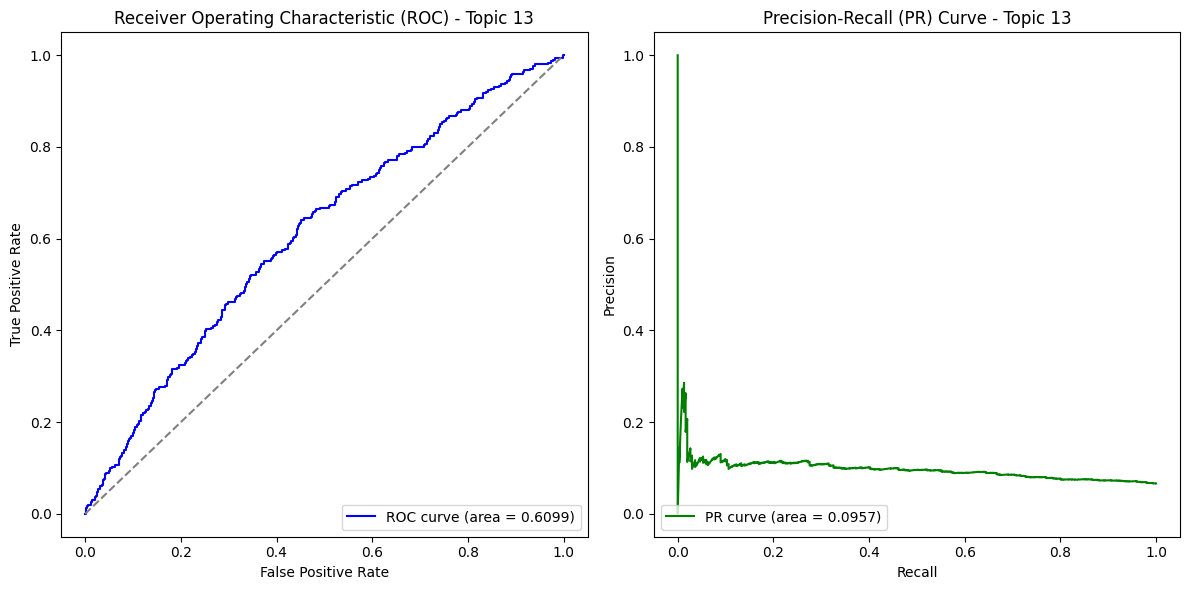

Evaluating topic 14
Topic 14 - auROC: 0.5486, auPR: 0.0858, F1: 0.0312


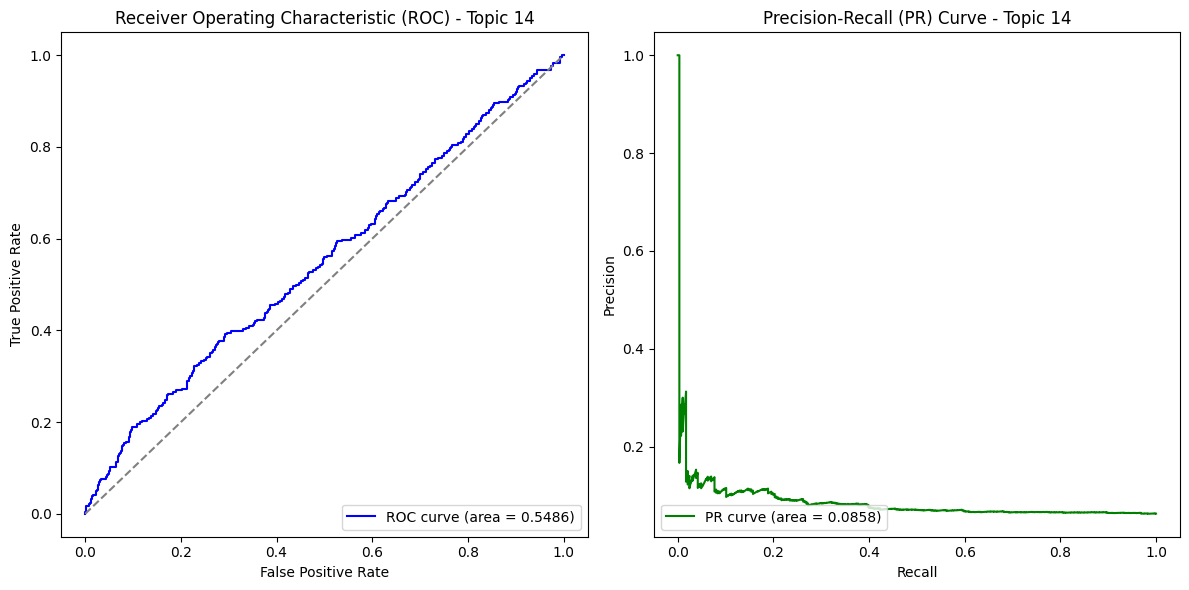

Evaluating topic 15
Topic 15 - auROC: 0.5432, auPR: 0.0790, F1: 0.0122


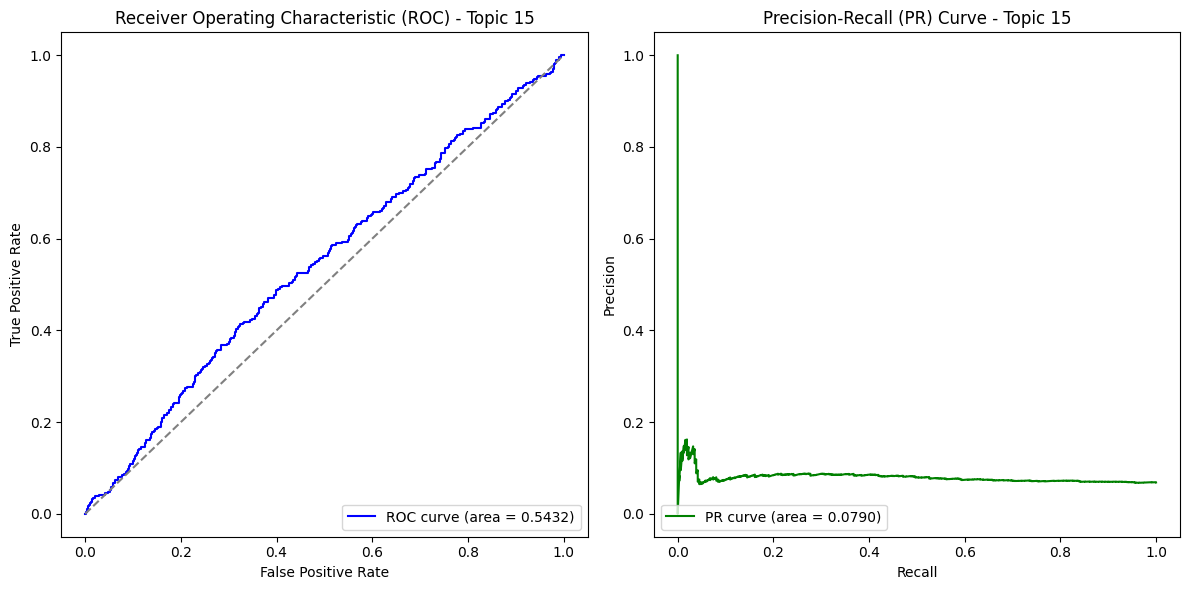

Evaluating topic 16
Topic 16 - auROC: 0.5922, auPR: 0.1019, F1: 0.0432


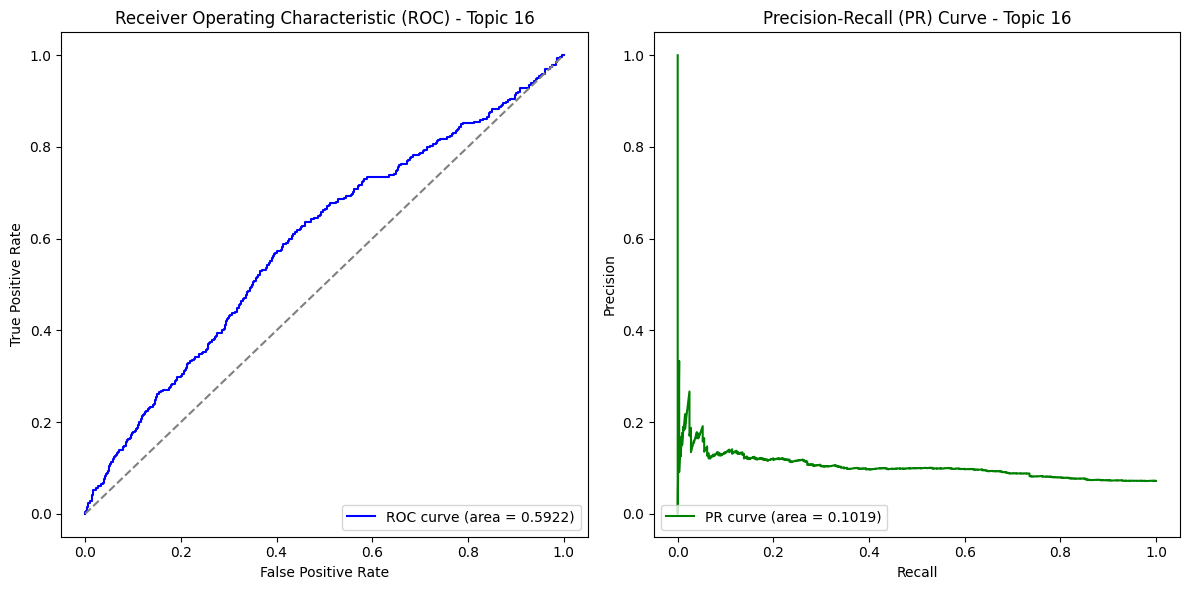

Evaluating topic 17
Topic 17 - auROC: 0.5516, auPR: 0.0777, F1: 0.0241


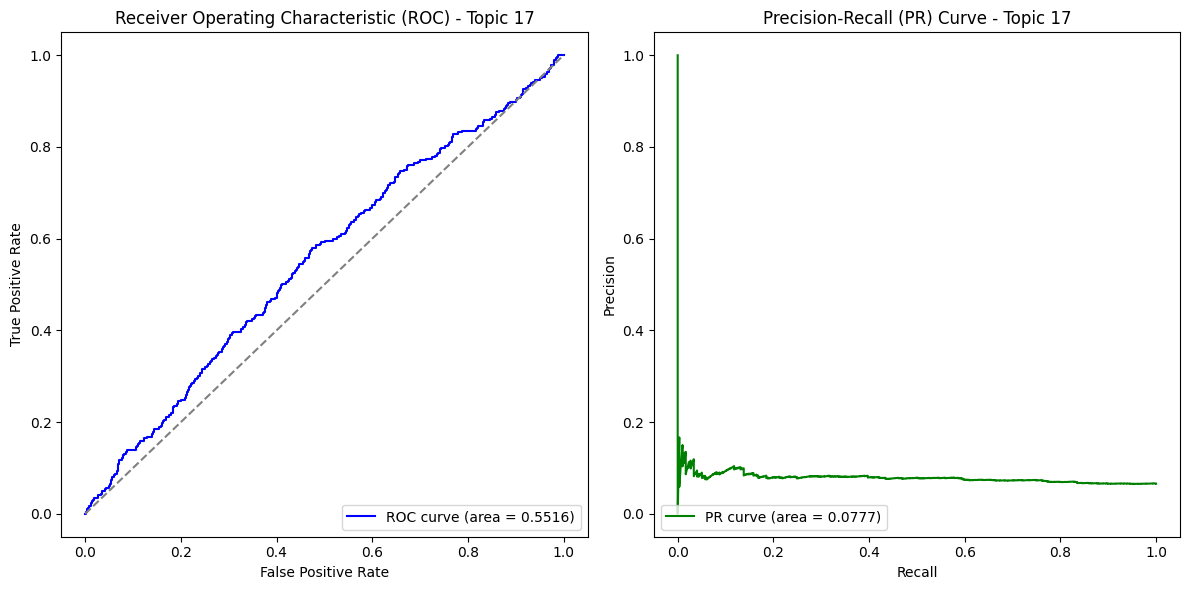

In [27]:
# Evaluate model performance for each topic
num_topics = y_test_np.shape[1]
auroc_values = []
aupr_values = []
f1_scores = []

print(f"\nEvaluating {num_topics} topics...")

for topic_idx in range(num_topics):
    print(f'Evaluating topic {topic_idx}')
    
    # Calculate ROC and PR metrics for the current topic
    fpr, tpr, _ = roc_curve(y_test_np[:, topic_idx], y_pred_np[:, topic_idx])
    roc_auc = auc(fpr, tpr)
    auroc_values.append(roc_auc)
    
    precision, recall, _ = precision_recall_curve(y_test_np[:, topic_idx], y_pred_np[:, topic_idx])
    pr_auc = auc(recall, precision)
    aupr_values.append(pr_auc)

    # Binarize predictions for F1 score calculation
    y_pred_bin = (y_pred_np[:, topic_idx] >= 0.5).astype(int)
    f1 = f1_score(y_test_np[:, topic_idx], y_pred_bin)
    f1_scores.append(f1)
    
    print(f'Topic {topic_idx} - auROC: {roc_auc:.4f}, auPR: {pr_auc:.4f}, F1: {f1:.4f}')
    
    # Plot ROC and PR curves for the current topic
    plt.figure(figsize=(12, 6))
    
    # ROC Curve
    plt.subplot(1, 2, 1)
    plt.plot(fpr, tpr, color='blue', label=f'ROC curve (area = {roc_auc:.4f})')
    plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'Receiver Operating Characteristic (ROC) - Topic {topic_idx}')
    plt.legend(loc='lower right')
    
    # PR Curve
    plt.subplot(1, 2, 2)
    plt.plot(recall, precision, color='green', label=f'PR curve (area = {pr_auc:.4f})')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(f'Precision-Recall (PR) Curve - Topic {topic_idx}')
    plt.legend(loc='lower left')
    
    plt.tight_layout()
    plt.show()

In [28]:
# Summary statistics
print(f"\nSummary Statistics:")
print(f"Mean auROC: {np.mean(auroc_values):.4f} ± {np.std(auroc_values):.4f}")
print(f"Mean auPR: {np.mean(aupr_values):.4f} ± {np.std(aupr_values):.4f}")
print(f"Mean F1: {np.mean(f1_scores):.4f} ± {np.std(f1_scores):.4f}")
print(f"Exact Match Accuracy: {exact_acc:.4f}")
print(f"Hamming Accuracy: {hamming_acc:.4f}")


Summary Statistics:
Mean auROC: 0.5589 ± 0.0338
Mean auPR: 0.0872 ± 0.0138
Mean F1: 0.0322 ± 0.0179
Exact Match Accuracy: 0.0021
Hamming Accuracy: 0.9255


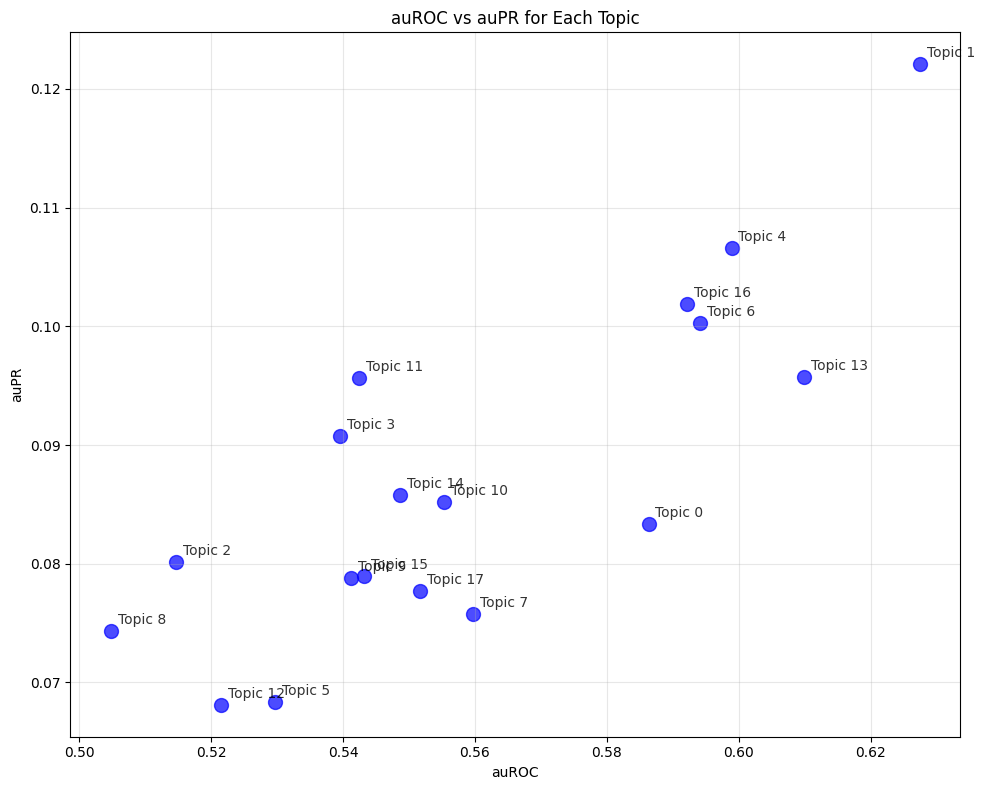

In [29]:
# Scatter plot of auROC vs auPR
plt.figure(figsize=(10, 8))
plt.scatter(auroc_values, aupr_values, color='blue', alpha=0.7, s=100, )
plt.xlabel('auROC')
plt.ylabel('auPR')
plt.title('auROC vs auPR for Each Topic')
plt.grid(True, alpha=0.3)

# Annotate each point with the topic index
for i, (x, y) in enumerate(zip(auroc_values, aupr_values)):
    plt.annotate(f'Topic {i}', (x, y), fontsize=10, alpha=0.8, 
                xytext=(5, 5), textcoords='offset points')

plt.tight_layout()
plt.show()

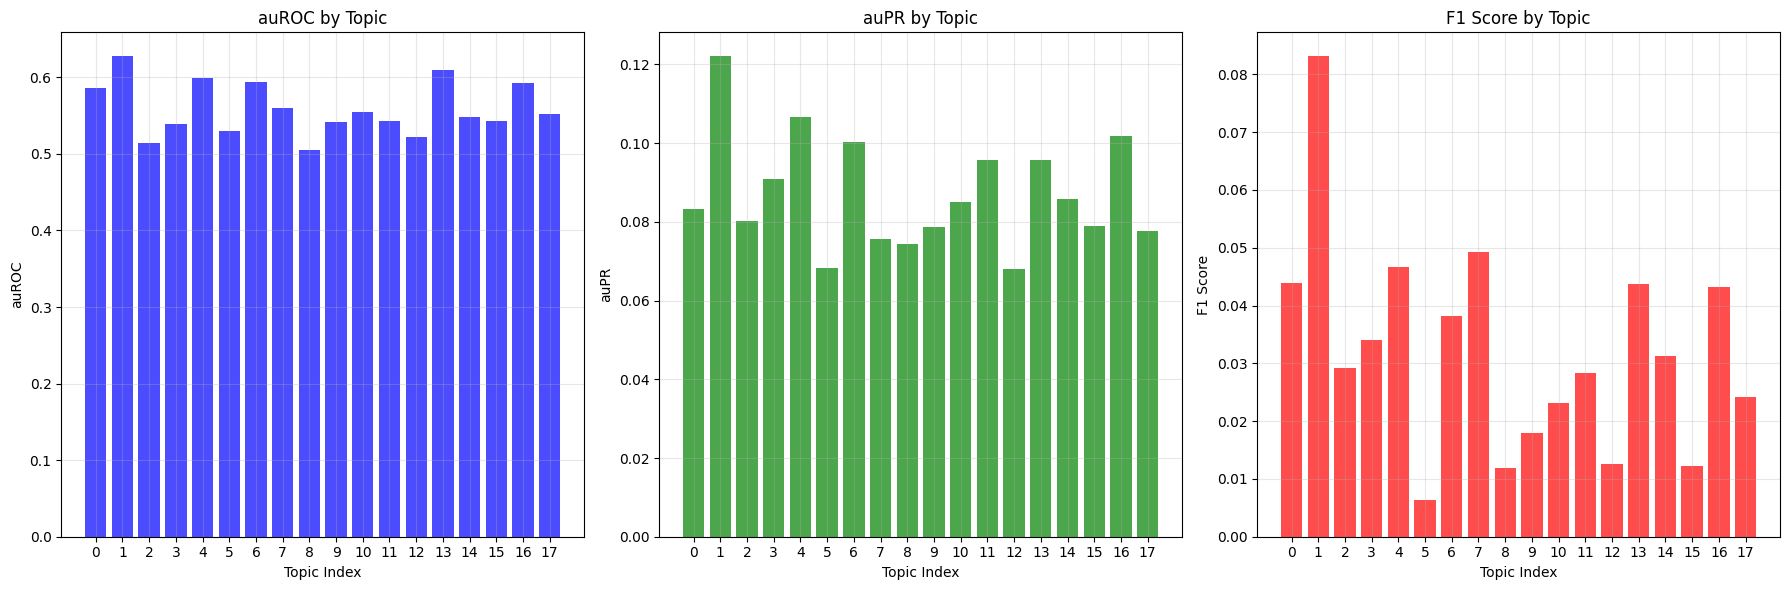

In [30]:
# Bar plots for metrics comparison
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# auROC bar plot
axes[0].bar(range(num_topics), auroc_values, color='blue', alpha=0.7)
axes[0].set_xlabel('Topic Index')
axes[0].set_ylabel('auROC')
axes[0].set_title('auROC by Topic')
axes[0].set_xticks(range(num_topics))
axes[0].grid(True, alpha=0.3)

# auPR bar plot
axes[1].bar(range(num_topics), aupr_values, color='green', alpha=0.7)
axes[1].set_xlabel('Topic Index')
axes[1].set_ylabel('auPR')
axes[1].set_title('auPR by Topic')
axes[1].set_xticks(range(num_topics))
axes[1].grid(True, alpha=0.3)

# F1 bar plot
axes[2].bar(range(num_topics), f1_scores, color='red', alpha=0.7)
axes[2].set_xlabel('Topic Index')
axes[2].set_ylabel('F1 Score')
axes[2].set_title('F1 Score by Topic')
axes[2].set_xticks(range(num_topics))
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

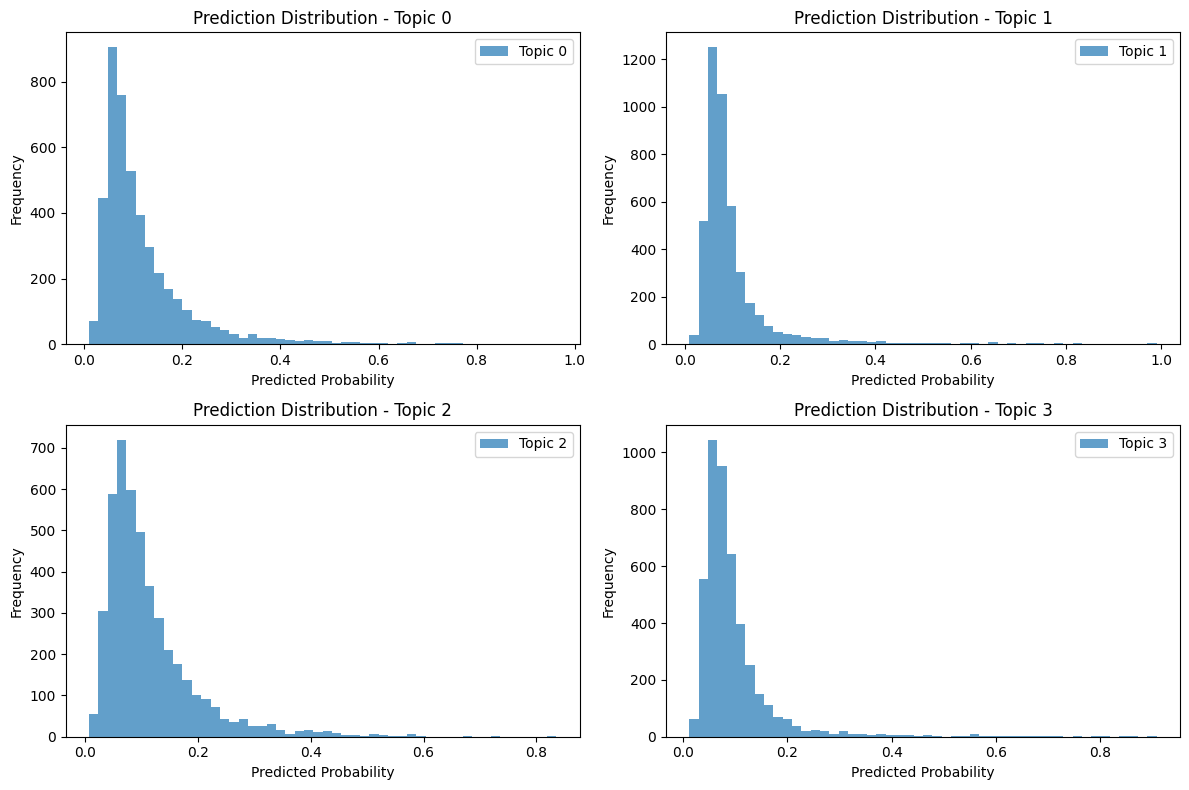


Sample predictions (first 10 samples):
Sample 0:
  Predicted: [0.08856354 0.40580052 0.05672337 0.18565549 0.1032544  0.10792176
 0.06891451 0.07285603 0.06254047 0.06690776 0.11444923 0.09510137
 0.04636337 0.10624176 0.14459743 0.07515602 0.08454379 0.07459989]
  Actual:    [0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
  Binary:    [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]

Sample 1:
  Predicted: [0.15074226 0.22185    0.06652182 0.25311083 0.09286508 0.15448684
 0.077081   0.11072829 0.08851499 0.06274035 0.10126898 0.18019564
 0.07388663 0.07851938 0.23671164 0.11608327 0.17807207 0.08924759]
  Actual:    [0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
  Binary:    [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]

Sample 2:
  Predicted: [0.12396836 0.07810427 0.12638736 0.08379057 0.12945631 0.1268869
 0.07486677 0.30090097 0.06106645 0.08708105 0.09734955 0.10006303
 0.13152611 0.0818572  0.06651228 0.077793   0.08030706 0.15122236]
  Actual:    [0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 

In [31]:
# Additional analysis: Prediction distribution
plt.figure(figsize=(12, 8))

# Histogram of predictions for each topic
for i in range(min(4, num_topics)):  # Show first 4 topics
    plt.subplot(2, 2, i+1)
    plt.hist(y_pred_np[:, i], bins=50, alpha=0.7, label=f'Topic {i}')
    plt.xlabel('Predicted Probability')
    plt.ylabel('Frequency')
    plt.title(f'Prediction Distribution - Topic {i}')
    plt.legend()

plt.tight_layout()
plt.show()

# Sample predictions vs targets
print("\nSample predictions (first 10 samples):")
for i in range(min(10, y_pred_np.shape[0])):
    print(f"Sample {i}:")
    print(f"  Predicted: {y_pred_np[i]}")
    print(f"  Actual:    {y_test_np[i]}")
    print(f"  Binary:    {(y_pred_np[i] > 0.5).astype(int)}")
    print()